# Analyse modale (exemple sur un système à 3 DDL)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.integrate import odeint
import scipy.fftpack
from scipy import signal
plt.rcParams['figure.figsize'] = [12, 3]
from scipy import optimize
import functools
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 

## Construction des matrices du système

\begin{equation}
\left[ M \right] \left\lbrace \ddot{q} \right\rbrace + \left[ B \right] \left\lbrace \dot{q} \right\rbrace + \left[ K \right] \left\lbrace q \right\rbrace = \left\lbrace 0 \right\rbrace
\end{equation}

In [3]:
l=1
mm0=np.array([[156,22*l,54,-13*l],[22*l,4*(l)**2,13*l,-3*(l)**2],[54,13*l,156,-22*l],[-13*l,-3*(l)**2,-22*l,4*(l)**2]]);
#mm0=(rho*S*l)/420
bb0=np.zeros((4,4));
kk0=np.array([[12,6*l,-12,6*l],[6*l,4*(l)**2,-6*l,2*(l)**2],[-12,-6*l,12,-6*l],[6*l,2*(l)**2,-6*l,4*(l)**2]]);
# kk0=(E*I)/l**3

mm=np.array([[156,22*l,54,-13*l],[22*l,4*(l)**2,13*l,-3*(l)**2],[54,13*l,156,-22*l],[-13*l,-3*(l)**2,-22*l,4*(l)**2]]);
bb=np.zeros((4,4))
kk=np.array([[12,6*l,-12,6*l],[6*l,4*(l)**2,-6*l,2*(l)**2],[-12,-6*l,12,-6*l],[6*l,2*(l)**2,-6*l,4*(l)**2]]);
Df=200/400;
frq=np.arange(Df,200,Df);

print("mm0 =\n",mm0)
print("bb0 =\n",bb0)
print("kk0 =\n",kk0)

# ----------------------------------------------------------------



mm0 =
 [[156  22  54 -13]
 [ 22   4  13  -3]
 [ 54  13 156 -22]
 [-13  -3 -22   4]]
bb0 =
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
kk0 =
 [[ 12   6 -12   6]
 [  6   4  -6   2]
 [-12  -6  12  -6]
 [  6   2  -6   4]]


## Réécriture du problème (prise en compte de l'amortissement)

\begin{equation}
\left[ \begin{array}{c c} \left[ 0 \right] & \left[ M \right] \\ \left[ M \right] & \left[ B \right] \end{array} \right] \left\lbrace \begin{array}{c} \left\lbrace \ddot{q} \right\rbrace \\ \left\lbrace \dot{q} \right\rbrace \end{array} \right\rbrace + \left[ \begin{array}{c c} \left[ -M \right] & \left[ 0 \right] \\ \left[ 0 \right] & \left[ K \right] \end{array} \right] \left\lbrace \begin{array}{c} \left\lbrace \dot{q} \right\rbrace \\ \left\lbrace q \right\rbrace \end{array} \right\rbrace = \left\lbrace \begin{array}{c} \left\lbrace 0 \right\rbrace \\ \left\lbrace 0 \right\rbrace \end{array} \right\rbrace
\end{equation}

In [4]:
ms1=np.concatenate((np.zeros(mm.shape), mm), axis=0);
ms2=np.concatenate((mm, bb), axis=0);
ms=np.concatenate((ms1, ms2), axis=1);
ks1=np.concatenate((-mm, np.zeros(mm.shape)), axis=0);
ks2=np.concatenate((np.zeros(mm.shape), kk), axis=0);
ks=np.concatenate((ks1, ks2), axis=1);

print("ms =",ms)
print("ks =",ks)

ms = [[  0.   0.   0.   0. 156.  22.  54. -13.]
 [  0.   0.   0.   0.  22.   4.  13.  -3.]
 [  0.   0.   0.   0.  54.  13. 156. -22.]
 [  0.   0.   0.   0. -13.  -3. -22.   4.]
 [156.  22.  54. -13.   0.   0.   0.   0.]
 [ 22.   4.  13.  -3.   0.   0.   0.   0.]
 [ 54.  13. 156. -22.   0.   0.   0.   0.]
 [-13.  -3. -22.   4.   0.   0.   0.   0.]]
ks = [[-156.  -22.  -54.   13.    0.    0.    0.    0.]
 [ -22.   -4.  -13.    3.    0.    0.    0.    0.]
 [ -54.  -13. -156.   22.    0.    0.    0.    0.]
 [  13.    3.   22.   -4.    0.    0.    0.    0.]
 [   0.    0.    0.    0.   12.    6.  -12.    6.]
 [   0.    0.    0.    0.    6.    4.   -6.    2.]
 [   0.    0.    0.    0.  -12.   -6.   12.   -6.]
 [   0.    0.    0.    0.    6.    2.   -6.    4.]]


## Résolution du problème aux valeurs propres pour résultats de référence

In [9]:
val_propres, vect_propres = la.eig(-np.dot(la.inv(ms),ks));
print("val_propres =", val_propres)
print("vect_propres =", vect_propres)

omegar=np.imag(val_propres);
print("pulsations propres (desordre) :");
print("omegar =",omegar);
o_omegar=np.argsort(omegar);
#print("o_omegar =",o_omegar);
print("******************************");
print("pulsations propres (ordre) :");
print("omegar[o_omegar] =",omegar[o_omegar][3:6:1]);
print("fr =",omegar[o_omegar][3:6:1]/2/np.pi);
br=-np.real(val_propres)/np.abs(val_propres);
print("******************************");
print("amortissements modaux (desordre) :");
print("br",br);

print("******************************");
print("amortissements modaux (ordre) :");
print("br[o_omegar] =",br[o_omegar][int(len/2):len:1]);
vps=np.concatenate((np.zeros((int(len/2),len)),vect_propres), axis=0)

print("******************************");
print("modes propres (desordre) :");
print("vps =",vps);

print("******************************");
print("modes propres (ordre) :");
print("vps[o_omegar] =",np.real(vps[0:4,o_omegar])[int(len/2):len:1]);
plt.figure();
plt.subplot(1,2,1);
plt.plot(range(1,4),omegar[o_omegar][int(len/2):len:1],'.-');
plt.xlabel("n");
plt.ylabel("$\omega_{n}$");
plt.subplot(1,2,2);
plt.plot(range(1,4),br[o_omegar][int(len/2):len:1],'.-');
plt.xlabel("n");
plt.ylabel("$b_{n}$");
plt.figure();
plt.plot(range(4),np.real(vps[0:4,o_omegar])[:,int(len/2):len:1],'.-');
plt.xlabel("n");
plt.ylabel("$\Phi_{n}$");
plt.legend(['mode 1','mode 2','mode 3'])

val_propres = [-2.91433544e-16+4.47213595e+00j -2.91433544e-16-4.47213595e+00j
  3.74700271e-16+1.30930734e+00j  3.74700271e-16-1.30930734e+00j
  5.90527214e-08+0.00000000e+00j -1.64146840e-17+8.59003290e-09j
 -1.64146840e-17-8.59003290e-09j -5.90527216e-08+0.00000000e+00j]
vect_propres = [[-5.73068255e-02+2.10344013e-18j -5.73068255e-02-2.10344013e-18j
  -9.23842554e-02-4.43685657e-16j -9.23842554e-02+4.43685657e-16j
   2.38114565e-08+0.00000000e+00j  2.78508168e-16-5.93301795e-09j
   2.78508168e-16+5.93301795e-09j  2.38114569e-08+0.00000000e+00j]
 [ 6.87681906e-01+0.00000000e+00j  6.87681906e-01-0.00000000e+00j
   5.54305532e-01+0.00000000e+00j  5.54305532e-01-0.00000000e+00j
  -3.70475636e-08+0.00000000e+00j  1.62968469e-16-2.67383293e-10j
   1.62968469e-16+2.67383293e-10j -3.70475634e-08+0.00000000e+00j]
 [ 5.73068255e-02+0.00000000e+00j  5.73068255e-02-0.00000000e+00j
  -9.23842554e-02+7.61156598e-17j -9.23842554e-02-7.61156598e-17j
  -1.32361068e-08+0.00000000e+00j  5.06762844e-1

TypeError: unsupported operand type(s) for /: 'builtin_function_or_method' and 'int'

## Définition de l'excitation (impulsion)

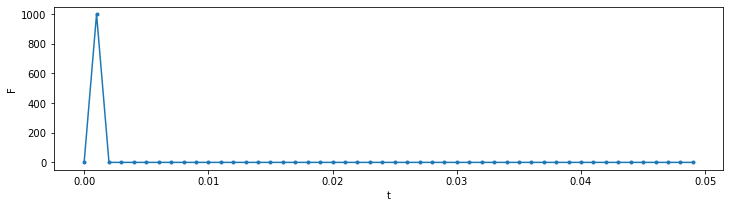

In [6]:
hh=0.001;
tt=np.arange(0,100,hh);
def force(t):
    tmax=hh;
    Fmax=1/tmax;
    if t<=tmax :
        f=t*Fmax/tmax;
    elif (t>tmax)and(t<=2*tmax) :
        f=-Fmax/tmax*t+2*Fmax;
    else :
        f=0
    return f

ff=np.zeros(tt.shape)
for ii in range(len(tt)):
    ff[ii]=force(tt[ii]);
    
plt.plot(tt[0:50],ff[0:50],'.-');
plt.xlabel('t');
plt.ylabel('F');

## Calcul des signaux temporels

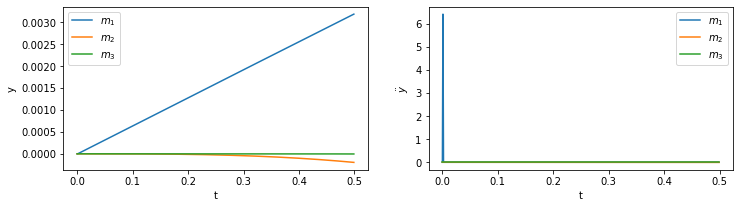

In [7]:
def cauchy(y,t):
    ydot=np.zeros(y.shape);
    ydot[0]=y[1];
    ydot[1]=(-bb[0,0]*y[1]-kk[0,0]*y[0]-kk[0,1]*y[2]+force(t))/mm[0,0];
    ydot[2]=y[3];
    ydot[3]=(-bb[1,1]*y[3]-kk[1,0]*y[0]-kk[1,1]*y[2]-kk[1,2]*y[4])/mm[1,1];
    ydot[4]=y[5];
    ydot[5]=(-bb[2,2]*y[5]-kk[2,1]*y[2]-kk[2,2]*y[4])/mm[1,1];
    return ydot

y0=np.array([0,0,0,0,0,0]);
yode=odeint(cauchy,y0,tt);

ydot=np.zeros(yode.shape);
for ii in range(len(tt)):
    ydot[ii,:]=cauchy(yode[ii,:],tt[ii]);

plt.figure();
plt.subplot(1,2,1);
plt.plot(tt[0:500],yode[0:500,0:5:2]);
plt.xlabel("t");
plt.ylabel("y");
plt.legend(['$m_{1}$','$m_{2}$','$m_{3}$'])
plt.subplot(1,2,2);
plt.plot(tt[0:500],ydot[0:500,1:6:2]);
plt.xlabel("t");
plt.ylabel("$\ddot{y}$");
plt.legend(['$m_{1}$','$m_{2}$','$m_{3}$'])

## Calcul des 3 FRFs (avec vérification par 2 méthodes à partir des résultats de référence)

In [8]:
# Calcul des 3 FRFs à partir des signaux temporels

NN=len(tt);
frq=np.arange(NN)/hh/NN;
#print(frq.shape)
#
f,Sxy11=signal.csd(ff,ydot[:,1],(NN-1)/NN/hh,window='boxcar',nperseg=2*8192);
f,Sxx11=signal.csd(ff,ff,(NN-1)/NN/hh,window='boxcar',nperseg=2*8192);
#plt.plot(f,np.abs(Sxy11),'b.-');
#plt.plot(f,np.abs(Sxx11),'r.-');
H11=Sxy11/Sxx11;
#
f,Sxy12=signal.csd(ff,ydot[:,3],(NN-1)/NN/hh,window='boxcar',nperseg=2*8192);
f,Sxx12=signal.csd(ff,ff,(NN-1)/NN/hh,window='boxcar',nperseg=2*8192);
#plt.plot(f,np.abs(Sxy12),'b.-');
#plt.plot(f,np.abs(Sxx12),'r.-');
H12=Sxy12/Sxx12;
#
f,Sxy13=signal.csd(ff,ydot[:,5],(NN-1)/NN/hh,window='boxcar',nperseg=2*8192);
f,Sxx13=signal.csd(ff,ff,(NN-1)/NN/hh,window='boxcar',nperseg=2*8192);
#plt.plot(f,np.abs(Sxy13),'b.-');
#plt.plot(f,np.abs(Sxx13),'r.-');
H13=Sxy13/Sxx13;
#

# Calcul de vérification méthode 1 (à partir des paramètres modaux issus de l'analyse aux valeurs propres)

inrt1=np.zeros(f.shape, dtype=complex);
inrt2=np.zeros(f.shape, dtype=complex);
inrt3=np.zeros(f.shape, dtype=complex);
#print("np.real(vps[1:4,o_omegar])[:,3:6:1] =",np.real(vps[1:4,o_omegar])[:,3:6:1]);

for i in range(len(f)):
    for r in range(3):
        #print("r =",r);
        #print("omegar[o_omegar][3+r] =",omegar[o_omegar][3+r]);
        #print("np.real(vps[1:4,o_omegar])[r,3] =",np.real(vps[1:4,o_omegar])[r,3]);
        #print("np.real(vps[1:4,o_omegar])[r,4] =",np.real(vps[1:4,o_omegar])[r,4]);
        #print("np.real(vps[1:4,o_omegar])[r,5] =",np.real(vps[1:4,o_omegar])[r,5]);
        #print("br[o_omegar][3+r] =",br[o_omegar][3+r]);
        inrt1[i]=inrt1[i]+(np.real(vps[1:4,o_omegar])[r,3])*(np.real(vps[1:4,o_omegar])[r,3])/((omegar[o_omegar][3+r]**2)-((2*np.pi*f[i])**2)+1j*2*br[o_omegar][3+r]*omegar[o_omegar][3+r]*2*np.pi*f[i]);
        inrt2[i]=inrt2[i]+(np.real(vps[1:4,o_omegar])[r,3])*(np.real(vps[1:4,o_omegar])[r,4])/((omegar[o_omegar][3+r]**2)-((2*np.pi*f[i])**2)+1j*2*br[o_omegar][3+r]*omegar[o_omegar][3+r]*2*np.pi*f[i]);
        inrt3[i]=inrt3[i]+(np.real(vps[1:4,o_omegar])[r,3])*(np.real(vps[1:4,o_omegar])[r,5])/((omegar[o_omegar][3+r]**2)-((2*np.pi*f[i])**2)+1j*2*br[o_omegar][3+r]*omegar[o_omegar][3+r]*2*np.pi*f[i]);

inrt1=-inrt1*(2*np.pi*f)**2; # passage de l'inertance à l'admittance
inrt2=-inrt2*(2*np.pi*f)**2;
inrt3=-inrt3*(2*np.pi*f)**2;

# Calcul de vérification méthode 2 (à partir des matrices M, B et K)

inrt1bis=np.zeros(f.shape, dtype=complex);
inrt2bis=np.zeros(f.shape, dtype=complex);
inrt3bis=np.zeros(f.shape, dtype=complex);
for i in range(len(f)):
    #print("i =",i);
    mbk=kk+1j*2*np.pi*f[i]*bb-((2*np.pi*f[i])**2)*mm;
    mbki=np.linalg.inv(mbk);  
    inrt1bis[i]=mbki[0,0];
    inrt2bis[i]=mbki[0,1];
    inrt3bis[i]=mbki[0,2];
    
inrt1bis=-inrt1bis*(2*np.pi*f)**2; # passage de l'inertance à l'admittance
inrt2bis=-inrt2bis*(2*np.pi*f)**2;
inrt3bis=-inrt3bis*(2*np.pi*f)**2;

# affichage de l'amplitude
plt.figure();
plt.subplot(1,3,1);
plt.plot(f,20*np.log10(np.abs(H11)));
plt.plot(f,20*np.log10(np.abs(inrt1)),'--');
plt.plot(f,20*np.log10(np.abs(inrt1bis)),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{11} \, [dB]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])
plt.subplot(1,3,2);
plt.plot(f,20*np.log10(np.abs(H12)));
plt.plot(f,20*np.log10(np.abs(inrt2)),'--');
plt.plot(f,20*np.log10(np.abs(inrt2bis)),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{12} \, [dB]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])
plt.title("Amplitude")
plt.subplot(1,3,3);
plt.plot(f,20*np.log10(np.abs(H13)));
plt.plot(f,20*np.log10(np.abs(inrt3)),'--');
plt.plot(f,20*np.log10(np.abs(inrt3bis)),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{13} \, [dB]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])

# affichage des cercles de Nyquist
plt.figure();
plt.subplot(1,3,1);
plt.plot(np.real(H11),np.imag(H11));
plt.plot(np.real(inrt1),np.imag(inrt1),'--');
plt.plot(np.real(inrt1bis),np.imag(inrt1bis),'-.');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])
plt.subplot(1,3,2);
plt.plot(np.real(H12),np.imag(H12));
plt.plot(-np.real(inrt2),-np.imag(inrt2),'--');
plt.plot(np.real(inrt2bis),np.imag(inrt2bis),'-.');
plt.xlabel("$H_{12} \, [real]$");
plt.ylabel("$H_{12} \, [imag]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])
plt.title("Diagramme de Nyquist")
plt.subplot(1,3,3);
plt.plot(np.real(H13),np.imag(H13));
plt.plot(-np.real(inrt3),-np.imag(inrt3),'--');
plt.plot(np.real(inrt3bis),np.imag(inrt3bis),'-.');
plt.xlabel("$H_{13} \, [real]$");
plt.ylabel("$H_{13} \, [imag]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])

# affichage partie réelle
plt.figure();
plt.subplot(1,3,1);
plt.plot(f,np.real(H11));
plt.plot(f,np.real(inrt1),'--');
plt.plot(f,np.real(inrt1bis),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{11} \, [real]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])
plt.subplot(1,3,2);
plt.plot(f,np.real(H12));
plt.plot(f,-np.real(inrt2),'--');
plt.plot(f,np.real(inrt2bis),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{12} \, [real]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])
plt.title("Partie réelle")
plt.subplot(1,3,3);
plt.plot(f,np.real(H13));
plt.plot(f,-np.real(inrt3),'--');
plt.plot(f,np.real(inrt3bis),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{13} \, [real]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])

# affichage de la partie imaginaire
plt.figure();
plt.subplot(1,3,1);
plt.plot(f,np.imag(H11));
plt.plot(f,np.imag(inrt1),'--');
plt.plot(f,np.imag(inrt1bis),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{11} \, [imag]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])
plt.subplot(1,3,2);
plt.plot(f,np.imag(H12));
plt.plot(f,-np.imag(inrt2),'--');
plt.plot(f,np.imag(inrt2bis),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{12} \, [imag]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])
plt.title("Partie imaginaire")
plt.subplot(1,3,3);
plt.plot(f,np.imag(H13));
plt.plot(f,-np.imag(inrt3),'--');
plt.plot(f,np.imag(inrt3bis),'-.');
plt.xlabel("$f$");
plt.ylabel("$H_{13} \, [imag]$");
plt.legend(['$H_{ref}$','$H_{verif}$','$H_{verif2}$'])

<ipython-input-8-773b822734a3>:11: RuntimeWarning: invalid value encountered in true_divide
  H11=Sxy11/Sxx11;
<ipython-input-8-773b822734a3>:17: RuntimeWarning: invalid value encountered in true_divide
  H12=Sxy12/Sxx12;
<ipython-input-8-773b822734a3>:23: RuntimeWarning: invalid value encountered in true_divide
  H13=Sxy13/Sxx13;


NameError: name 'vps' is not defined

# Peak picking

### 1- Identifier les pics des différents modes $k$ sur le tracé de la FRF, ainsi que leur amplitude $\vert \alpha_{k} \vert_{max}$.
### 2- Calculer les bandes passantes à -3dB ($\vert \alpha_{k} \vert_{max}/\sqrt{2}$) et les pulsations associées $\omega_{k,a}$ et $\omega_{k,b}$, pour chacun des pics.
### 3- Calculer les taux d'amortissement modaux :
\begin{equation}
b_{k}=\frac{1}{2}\frac{\omega_{k,a}^{2}-\omega_{k,b}^{2}}{\omega_{k}^{2}} \approx \frac{1}{2} \frac{\omega_{k,a}-\omega_{k,b}}{\omega_{k}}
\end{equation}

## FRF 1

In [ ]:
ipeak_H11_m1=range(2*200,2*600);
ipeak_H11_m2=range(2*640,2*920);
ipeak_H11_m3=range(2*960,2*1320);

plt.figure();
plt.subplot(1,3,1);
#plt.plot(f,np.abs(H11),'.-');
plt.plot(f[ipeak_H11_m1],np.abs(H11[ipeak_H11_m1]),'.--');
plt.ylabel("$|H_{11}|$");
plt.legend(["mode 1"]);
plt.subplot(1,3,2);
#plt.plot(f,np.abs(H11),'.-');
plt.plot(f[ipeak_H11_m2],np.abs(H11[ipeak_H11_m2]),'.--');
plt.ylabel("$|H_{11}|$");
plt.legend(["mode 2"]);
plt.subplot(1,3,3);
#plt.plot(f,np.abs(H11),'.-');
plt.plot(f[ipeak_H11_m3],np.abs(H11[ipeak_H11_m3]),'.--');
plt.ylabel("$|H_{11}|$");
plt.legend(["mode 3"]);

# mode 1
imax_H11_m1=0;Hmax_H11_m1=-1000;
for i in ipeak_H11_m1:
    if np.abs(H11[i])>Hmax_H11_m1:
        imax_H11_m1=i;
        Hmax_H11_m1=np.abs(H11[i]);
#print("imax_H11_m1",imax_H11_m1);
#print("np.abs(H11[imax_H11_m1])",np.abs(H11[imax_H11_m1]));
#print("f[imax_H11_m1]",f[imax_H11_m1]);

i3dB_H11_m1=0;i3dB_H11_m1bis=0;H3dB_H11_m1=1000;H3dB_H11_m1bis=1000;
for i in ipeak_H11_m1:
    if (np.abs((np.abs(H11[i])-np.abs(H11[imax_H11_m1])/np.sqrt(2)))<H3dB_H11_m1)and(i<imax_H11_m1):
        i3dB_H11_m1=i;
        H3dB_H11_m1=np.abs(np.abs(H11[i])-np.abs(H11[imax_H11_m1])/np.sqrt(2));
    elif (np.abs((np.abs(H11[i])-np.abs(H11[imax_H11_m1])/np.sqrt(2)))<H3dB_H11_m1bis)and(i>imax_H11_m1):
        i3dB_H11_m1bis=i;
        H3dB_H11_m1bis=np.abs(np.abs(H11[i])-np.abs(H11[imax_H11_m1])/np.sqrt(2));
#print("i3dB_H11_m1",i3dB_H11_m1);
#print("np.abs(H11[i3dB_H11_m1])",np.abs(H11[i3dB_H11_m1]),np.abs(H11[imax_H11_m1])/np.sqrt(2));
#print("f[i3dB_H11_m1]",f[i3dB_H11_m1]);
#print("i3dB_H11_m1bis",i3dB_H11_m1bis);
#print("np.abs(H11[i3dB_H11_m1bis])",np.abs(H11[i3dB_H11_m1bis]),np.abs(H11[imax_H11_m1])/np.sqrt(2));
#print("f[i3dB_H11_m1bis]",f[i3dB_H11_m1bis]);

# mode 2
imax_H11_m2=0;Hmax_H11_m2=-1000;
for i in ipeak_H11_m2:
    if np.abs(H11[i])>Hmax_H11_m2:
        imax_H11_m2=i;
        Hmax_H11_m2=np.abs(H11[i]);
#print("imax_H11_m2",imax_H11_m2);
#print("np.abs(H11[imax_H11_m2])",np.abs(H11[imax_H11_m2]));
#print("f[imax_H11_m2]",f[imax_H11_m2]);

i3dB_H11_m2=0;i3dB_H11_m2bis=0;H3dB_H11_m2=1000;H3dB_H11_m2bis=1000;
for i in ipeak_H11_m2:
    if (np.abs((np.abs(H11[i])-np.abs(H11[imax_H11_m2])/np.sqrt(2)))<H3dB_H11_m2)and(i<imax_H11_m2):
        i3dB_H11_m2=i;
        H3dB_H11_m2=np.abs(np.abs(H11[i])-np.abs(H11[imax_H11_m2])/np.sqrt(2));
    elif (np.abs((np.abs(H11[i])-np.abs(H11[imax_H11_m2])/np.sqrt(2)))<H3dB_H11_m2bis)and(i>imax_H11_m2):
        i3dB_H11_m2bis=i;
        H3dB_H11_m2bis=np.abs(np.abs(H11[i])-np.abs(H11[imax_H11_m2])/np.sqrt(2));
#print("i3dB_H11_m2",i3dB_H11_m2);
#print("np.abs(H11[i3dB_H11_m2])",np.abs(H11[i3dB_H11_m2]),np.abs(H11[imax_H11_m2])/np.sqrt(2));
#print("f[i3dB_H11_m2]",f[i3dB_H11_m2]);
#print("i3dB_H11_m2bis",i3dB_H11_m2bis);
#print("np.abs(H11[i3dB_H11_m2bis])",np.abs(H11[i3dB_H11_m2bis]),np.abs(H11[imax_H11_m2])/np.sqrt(2));
#print("f[i3dB_H11_m2bis]",f[i3dB_H11_m2bis]);

# mode 3
imax_H11_m3=0;Hmax_H11_m3=-1000;
for i in ipeak_H11_m3:
    if np.abs(H11[i])>Hmax_H11_m3:
        imax_H11_m3=i;
        Hmax_H11_m3=np.abs(H11[i]);
#print("imax_H11_m3",imax_H11_m3);
#print("np.abs(H11[imax_H11_m3])",np.abs(H11[imax_H11_m3]));
#print("f[imax_H11_m3]",f[imax_H11_m3]);

i3dB_H11_m3=0;i3dB_H11_m3bis=0;H3dB_H11_m3=1000;H3dB_H11_m3bis=1000;
for i in ipeak_H11_m3:
    if (np.abs((np.abs(H11[i])-np.abs(H11[imax_H11_m3])/np.sqrt(2)))<H3dB_H11_m3)and(i<imax_H11_m3):
        i3dB_H11_m3=i;
        H3dB_H11_m3=np.abs(np.abs(H11[i])-np.abs(H11[imax_H11_m3])/np.sqrt(2));
    elif (np.abs((np.abs(H11[i])-np.abs(H11[imax_H11_m3])/np.sqrt(2)))<H3dB_H11_m3bis)and(i>imax_H11_m3):
        i3dB_H11_m3bis=i;
        H3dB_H11_m3bis=np.abs(np.abs(H11[i])-np.abs(H11[imax_H11_m3])/np.sqrt(2));
#print("i3dB_H11_m3",i3dB_H11_m3);
#print("np.abs(H11[i3dB_H11_m3])",np.abs(H11[i3dB_H11_m3]),np.abs(H11[imax_H11_m3])/np.sqrt(2));
#print("f[i3dB_H11_m3]",f[i3dB_H11_m3]);
#print("i3dB_H11_m3bis",i3dB_H11_m3bis);
#print("np.abs(H11[i3dB_H11_m3bis])",np.abs(H11[i3dB_H11_m3bis]),np.abs(H11[imax_H11_m3])/np.sqrt(2));
#print("f[i3dB_H11_m3bis]",f[i3dB_H11_m3bis]);

plt.subplot(1,3,1);
plt.plot(f[imax_H11_m1],np.abs(H11[imax_H11_m1]),'r*');
plt.plot(f[i3dB_H11_m1],np.abs(H11[i3dB_H11_m1]),'c*');
plt.plot(f[i3dB_H11_m1bis],np.abs(H11[i3dB_H11_m1bis]),'c*');
plt.plot(f[ipeak_H11_m1],np.abs(H11[imax_H11_m1])/np.sqrt(2)*np.ones(len(ipeak_H11_m1)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{11}|$");
plt.subplot(1,3,2);
plt.plot(f[imax_H11_m2],np.abs(H11[imax_H11_m2]),'r*');
plt.plot(f[i3dB_H11_m2],np.abs(H11[i3dB_H11_m2]),'c*');
plt.plot(f[i3dB_H11_m2bis],np.abs(H11[i3dB_H11_m2bis]),'c*');
plt.plot(f[ipeak_H11_m2],np.abs(H11[imax_H11_m2])/np.sqrt(2)*np.ones(len(ipeak_H11_m2)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{11}|$");
plt.title("FRF 1")
plt.subplot(1,3,3);
plt.plot(f[imax_H11_m3],np.abs(H11[imax_H11_m3]),'r*');
plt.plot(f[i3dB_H11_m3],np.abs(H11[i3dB_H11_m3]),'c*');
plt.plot(f[i3dB_H11_m3bis],np.abs(H11[i3dB_H11_m3bis]),'c*');
plt.plot(f[ipeak_H11_m3],np.abs(H11[imax_H11_m3])/np.sqrt(2)*np.ones(len(ipeak_H11_m3)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{11}|$");

imax_H11=[imax_H11_m1,imax_H11_m2,imax_H11_m3];
i3dB_H11=[i3dB_H11_m1,i3dB_H11_m2,i3dB_H11_m3];
i3dB_H11bis=[i3dB_H11_m1bis,i3dB_H11_m2bis,i3dB_H11_m3bis];

br_pp_H11=(f[i3dB_H11bis]-f[i3dB_H11])/f[imax_H11]/2;

## FRF 2

In [ ]:
ipeak_H12_m1=range(2*280,2*560);
ipeak_H12_m2=range(2*640,2*800);
ipeak_H12_m3=range(2*840,2*1320);

plt.figure();
plt.subplot(1,3,1);
#plt.plot(f,np.abs(H12),'.-');
plt.plot(f[ipeak_H12_m1],np.abs(H12[ipeak_H12_m1]),'.--');
plt.ylabel("$|H_{12}|$");
plt.legend(["mode 1"]);
plt.subplot(1,3,2);
#plt.plot(f,np.abs(H12),'.-');
plt.plot(f[ipeak_H12_m2],np.abs(H12[ipeak_H12_m2]),'.--');
plt.ylabel("$|H_{12}|$");
plt.legend(["mode 2"]);
plt.subplot(1,3,3);
#plt.plot(f,np.abs(H12),'.-');
plt.plot(f[ipeak_H12_m3],np.abs(H12[ipeak_H12_m3]),'.--');
plt.ylabel("$|H_{12}|$");
plt.legend(["mode 3"]);

# mode 1
imax_H12_m1=0;Hmax_H12_m1=-1000;
for i in ipeak_H12_m1:
    if np.abs(H12[i])>Hmax_H12_m1:
        imax_H12_m1=i;
        Hmax_H12_m1=np.abs(H12[i]);
#print("imax_H12_m1",imax_H12_m1);
#print("np.abs(H12[imax_H12_m1])",np.abs(H12[imax_H12_m1]));
#print("f[imax_H12_m1]",f[imax_H12_m1]);

i3dB_H12_m1=0;i3dB_H12_m1bis=0;H3dB_H12_m1=1000;H3dB_H12_m1bis=1000;
for i in ipeak_H12_m1:
    if (np.abs((np.abs(H12[i])-np.abs(H12[imax_H12_m1])/np.sqrt(2)))<H3dB_H12_m1)and(i<imax_H12_m1):
        i3dB_H12_m1=i;
        H3dB_H12_m1=np.abs(np.abs(H12[i])-np.abs(H12[imax_H12_m1])/np.sqrt(2));
    elif (np.abs((np.abs(H12[i])-np.abs(H12[imax_H12_m1])/np.sqrt(2)))<H3dB_H12_m1bis)and(i>imax_H12_m1):
        i3dB_H12_m1bis=i;
        H3dB_H12_m1bis=np.abs(np.abs(H12[i])-np.abs(H12[imax_H12_m1])/np.sqrt(2));
#print("i3dB_H12_m1",i3dB_H12_m1);
#print("np.abs(H12[i3dB_H12_m1])",np.abs(H12[i3dB_H12_m1]),np.abs(H12[imax_H12_m1])/np.sqrt(2));
#print("f[i3dB_H12_m1]",f[i3dB_H12_m1]);
#print("i3dB_H12_m1bis",i3dB_H12_m1bis);
#print("np.abs(H12[i3dB_H12_m1bis])",np.abs(H12[i3dB_H12_m1bis]),np.abs(H12[imax_H12_m1])/np.sqrt(2));
#print("f[i3dB_H12_m1bis]",f[i3dB_H12_m1bis]);

# mode 2
imax_H12_m2=0;Hmax_H12_m2=-1000;
for i in ipeak_H12_m2:
    if np.abs(H12[i])>Hmax_H12_m2:
        imax_H12_m2=i;
        Hmax_H12_m2=np.abs(H12[i]);
#print("imax_H12_m2",imax_H12_m2);
#print("np.abs(H12[imax_H12_m2])",np.abs(H12[imax_H12_m2]));
#print("f[imax_H12_m2]",f[imax_H12_m2]);

i3dB_H12_m2=0;i3dB_H12_m2bis=0;H3dB_H12_m2=1000;H3dB_H12_m2bis=1000;
for i in ipeak_H12_m2:
    if (np.abs((np.abs(H12[i])-np.abs(H12[imax_H12_m2])/np.sqrt(2)))<H3dB_H12_m2)and(i<imax_H12_m2):
        i3dB_H12_m2=i;
        H3dB_H12_m2=np.abs(np.abs(H12[i])-np.abs(H12[imax_H12_m2])/np.sqrt(2));
    elif (np.abs((np.abs(H12[i])-np.abs(H12[imax_H12_m2])/np.sqrt(2)))<H3dB_H12_m2bis)and(i>imax_H12_m2):
        i3dB_H12_m2bis=i;
        H3dB_H12_m2bis=np.abs(np.abs(H12[i])-np.abs(H12[imax_H12_m2])/np.sqrt(2));
#print("i3dB_H12_m2",i3dB_H12_m2);
#print("np.abs(H12[i3dB_H12_m2])",np.abs(H12[i3dB_H12_m2]),np.abs(H12[imax_H12_m2])/np.sqrt(2));
#print("f[i3dB_H12_m2]",f[i3dB_H12_m2]);
#print("i3dB_H12_m2bis",i3dB_H12_m2bis);
#print("np.abs(H12[i3dB_H12_m2bis])",np.abs(H12[i3dB_H12_m2bis]),np.abs(H12[imax_H12_m2])/np.sqrt(2));
#print("f[i3dB_H12_m2bis]",f[i3dB_H12_m2bis]);

# mode 3
imax_H12_m3=0;Hmax_H12_m3=-1000;
for i in ipeak_H12_m3:
    if np.abs(H12[i])>Hmax_H12_m3:
        imax_H12_m3=i;
        Hmax_H12_m3=np.abs(H12[i]);
#print("imax_H12_m3",imax_H12_m3);
#print("np.abs(H12[imax_H12_m3])",np.abs(H12[imax_H12_m3]));
#print("f[imax_H12_m3]",f[imax_H12_m3]);

i3dB_H12_m3=0;i3dB_H12_m3bis=0;H3dB_H12_m3=1000;H3dB_H12_m3bis=1000;
for i in ipeak_H12_m3:
    if (np.abs((np.abs(H12[i])-np.abs(H12[imax_H12_m3])/np.sqrt(2)))<H3dB_H12_m3)and(i<imax_H12_m3):
        i3dB_H12_m3=i;
        H3dB_H12_m3=np.abs(np.abs(H12[i])-np.abs(H12[imax_H12_m3])/np.sqrt(2));
    elif (np.abs((np.abs(H12[i])-np.abs(H12[imax_H12_m3])/np.sqrt(2)))<H3dB_H12_m3bis)and(i>imax_H12_m3):
        i3dB_H12_m3bis=i;
        H3dB_H12_m3bis=np.abs(np.abs(H12[i])-np.abs(H12[imax_H12_m3])/np.sqrt(2));
#print("i3dB_H12_m3",i3dB_H12_m3);
#print("np.abs(H12[i3dB_H12_m3])",np.abs(H12[i3dB_H12_m3]),np.abs(H12[imax_H12_m3])/np.sqrt(2));
#print("f[i3dB_H12_m3]",f[i3dB_H12_m3]);
#print("i3dB_H12_m3bis",i3dB_H12_m3bis);
#print("np.abs(H12[i3dB_H12_m3bis])",np.abs(H12[i3dB_H12_m3bis]),np.abs(H12[imax_H12_m3])/np.sqrt(2));
#print("f[i3dB_H12_m3bis]",f[i3dB_H12_m3bis]);

plt.subplot(1,3,1);
plt.plot(f[imax_H12_m1],np.abs(H12[imax_H12_m1]),'r*');
plt.plot(f[i3dB_H12_m1],np.abs(H12[i3dB_H12_m1]),'c*');
plt.plot(f[i3dB_H12_m1bis],np.abs(H12[i3dB_H12_m1bis]),'c*');
plt.plot(f[ipeak_H12_m1],np.abs(H12[imax_H12_m1])/np.sqrt(2)*np.ones(len(ipeak_H12_m1)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{12}|$");
plt.subplot(1,3,2);
plt.plot(f[imax_H12_m2],np.abs(H12[imax_H12_m2]),'r*');
plt.plot(f[i3dB_H12_m2],np.abs(H12[i3dB_H12_m2]),'c*');
plt.plot(f[i3dB_H12_m2bis],np.abs(H12[i3dB_H12_m2bis]),'c*');
plt.plot(f[ipeak_H12_m2],np.abs(H12[imax_H12_m2])/np.sqrt(2)*np.ones(len(ipeak_H12_m2)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{12}|$");
plt.title("FRF 2")
plt.subplot(1,3,3);
plt.plot(f[imax_H12_m3],np.abs(H12[imax_H12_m3]),'r*');
plt.plot(f[i3dB_H12_m3],np.abs(H12[i3dB_H12_m3]),'c*');
plt.plot(f[i3dB_H12_m3bis],np.abs(H12[i3dB_H12_m3bis]),'c*');
plt.plot(f[ipeak_H12_m3],np.abs(H12[imax_H12_m3])/np.sqrt(2)*np.ones(len(ipeak_H12_m3)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{12}|$");

imax_H12=[imax_H12_m1,imax_H12_m2,imax_H12_m3];
i3dB_H12=[i3dB_H12_m1,i3dB_H12_m2,i3dB_H12_m3];
i3dB_H12bis=[i3dB_H12_m1bis,i3dB_H12_m2bis,i3dB_H12_m3bis];

br_pp_H12=(f[i3dB_H12bis]-f[i3dB_H12])/f[imax_H12]/2;

## FRF 3

In [ ]:
ipeak_H13_m1=range(2*280,2*520);
ipeak_H13_m2=range(2*560,2*880);
ipeak_H13_m3=range(2*900,2*1320);

plt.figure();
plt.subplot(1,3,1);
#plt.plot(f,np.abs(H13),'.-');
plt.plot(f[ipeak_H13_m1],np.abs(H13[ipeak_H13_m1]),'.--');
plt.ylabel("$|H_{12}|$");
plt.legend(["mode 1"]);
plt.subplot(1,3,2);
#plt.plot(f,np.abs(H13),'.-');
plt.plot(f[ipeak_H13_m2],np.abs(H13[ipeak_H13_m2]),'.--');
plt.ylabel("$|H_{12}|$");
plt.legend(["mode 2"]);
plt.subplot(1,3,3);
#plt.plot(f,np.abs(H13),'.-');
plt.plot(f[ipeak_H13_m3],np.abs(H13[ipeak_H13_m3]),'.--');
plt.ylabel("$|H_{12}|$");
plt.legend(["mode 3"]);

imax_H13_m1=0;Hmax_H13_m1=-1000;
for i in ipeak_H13_m1:
    if np.abs(H13[i])>Hmax_H13_m1:
        imax_H13_m1=i;
        Hmax_H13_m1=np.abs(H13[i]);
#print("imax_H13_m1",imax_H13_m1);
#print("np.abs(H13[imax_H13_m1])",np.abs(H13[imax_H13_m1]));
print("f[imax_H13_m1]",f[imax_H13_m1]);

i3dB_H13_m1=0;i3dB_H13_m1bis=0;H3dB_H13_m1=1000;H3dB_H13_m1bis=1000;
for i in ipeak_H13_m1:
    if (np.abs((np.abs(H13[i])-np.abs(H13[imax_H13_m1])/np.sqrt(2)))<H3dB_H13_m1)and(i<imax_H13_m1):
        i3dB_H13_m1=i;
        H3dB_H13_m1=np.abs(np.abs(H13[i])-np.abs(H13[imax_H13_m1])/np.sqrt(2));
    elif (np.abs((np.abs(H13[i])-np.abs(H13[imax_H13_m1])/np.sqrt(2)))<H3dB_H13_m1bis)and(i>imax_H13_m1):
        i3dB_H13_m1bis=i;
        H3dB_H13_m1bis=np.abs(np.abs(H13[i])-np.abs(H13[imax_H13_m1])/np.sqrt(2));
#print("i3dB_H13_m1",i3dB_H13_m1);
#print("np.abs(H13[i3dB_H13_m1])",np.abs(H13[i3dB_H13_m1]),np.abs(H13[imax_H13_m1])/np.sqrt(2));
print("f[i3dB_H13_m1]",f[i3dB_H13_m1]);
#print("i3dB_H13_m1bis",i3dB_H13_m1bis);
#print("np.abs(H13[i3dB_H13_m1bis])",np.abs(H13[i3dB_H13_m1bis]),np.abs(H13[imax_H13_m1])/np.sqrt(2));
print("f[i3dB_H13_m1bis]",f[i3dB_H13_m1bis]);

imax_H13_m2=0;Hmax_H13_m2=-1000;
for i in ipeak_H13_m2:
    if np.abs(H13[i])>Hmax_H13_m2:
        imax_H13_m2=i;
        Hmax_H13_m2=np.abs(H13[i]);
#print("imax_H13_m2",imax_H13_m2);
#print("np.abs(H13[imax_H13_m2])",np.abs(H13[imax_H13_m2]));
print("f[imax_H13_m2]",f[imax_H13_m2]);

i3dB_H13_m2=0;i3dB_H13_m2bis=0;H3dB_H13_m2=1000;H3dB_H13_m2bis=1000;
for i in ipeak_H13_m2:
    if (np.abs((np.abs(H13[i])-np.abs(H13[imax_H13_m2])/np.sqrt(2)))<H3dB_H13_m2)and(i<imax_H13_m2):
        i3dB_H13_m2=i;
        H3dB_H13_m2=np.abs(np.abs(H13[i])-np.abs(H13[imax_H13_m2])/np.sqrt(2));
    elif (np.abs((np.abs(H13[i])-np.abs(H13[imax_H13_m2])/np.sqrt(2)))<H3dB_H13_m2bis)and(i>imax_H13_m2):
        i3dB_H13_m2bis=i;
        H3dB_H13_m2bis=np.abs(np.abs(H13[i])-np.abs(H13[imax_H13_m2])/np.sqrt(2));
#print("i3dB_H13_m2",i3dB_H13_m2);
#print("np.abs(H13[i3dB_H13_m2])",np.abs(H13[i3dB_H13_m2]),np.abs(H13[imax_H13_m2])/np.sqrt(2));
print("f[i3dB_H13_m2]",f[i3dB_H13_m2]);
#print("i3dB_H13_m2bis",i3dB_H13_m2bis);
#print("np.abs(H13[i3dB_H13_m2bis])",np.abs(H13[i3dB_H13_m2bis]),np.abs(H13[imax_H13_m2])/np.sqrt(2));
print("f[i3dB_H13_m2bis]",f[i3dB_H13_m2bis]);

imax_H13_m3=0;Hmax_H13_m3=-1000;
for i in ipeak_H13_m3:
    if np.abs(H13[i])>Hmax_H13_m3:
        imax_H13_m3=i;
        Hmax_H13_m3=np.abs(H13[i]);
#print("imax_H13_m3",imax_H13_m3);
#print("np.abs(H13[imax_H13_m3])",np.abs(H13[imax_H13_m3]));
print("f[imax_H13_m3]",f[imax_H13_m3]);

i3dB_H13_m3=0;i3dB_H13_m3bis=0;H3dB_H13_m3=1000;H3dB_H13_m3bis=1000;
for i in ipeak_H13_m3:
    if (np.abs((np.abs(H13[i])-np.abs(H13[imax_H13_m3])/np.sqrt(2)))<H3dB_H13_m3)and(i<imax_H13_m3):
        i3dB_H13_m3=i;
        H3dB_H13_m3=np.abs(np.abs(H13[i])-np.abs(H13[imax_H13_m3])/np.sqrt(2));
    elif (np.abs((np.abs(H13[i])-np.abs(H13[imax_H13_m3])/np.sqrt(2)))<H3dB_H13_m3bis)and(i>imax_H13_m3):
        i3dB_H13_m3bis=i;
        H3dB_H13_m3bis=np.abs(np.abs(H13[i])-np.abs(H13[imax_H13_m3])/np.sqrt(2));
#print("i3dB_H13_m3",i3dB_H13_m3);
#print("np.abs(H13[i3dB_H13_m3])",np.abs(H13[i3dB_H13_m3]),np.abs(H13[imax_H13_m3])/np.sqrt(2));
print("f[i3dB_H13_m3]",f[i3dB_H13_m3]);
#print("i3dB_H13_m3bis",i3dB_H13_m3bis);
#print("np.abs(H13[i3dB_H13_m3bis])",np.abs(H13[i3dB_H13_m3bis]),np.abs(H13[imax_H13_m3])/np.sqrt(2));
print("f[i3dB_H13_m3bis]",f[i3dB_H13_m3bis]);

plt.subplot(1,3,1);
plt.plot(f[imax_H13_m1],np.abs(H13[imax_H13_m1]),'r*');
plt.plot(f[i3dB_H13_m1],np.abs(H13[i3dB_H13_m1]),'c*');
plt.plot(f[i3dB_H13_m1bis],np.abs(H13[i3dB_H13_m1bis]),'c*');
plt.plot(f[ipeak_H13_m1],np.abs(H13[imax_H13_m1])/np.sqrt(2)*np.ones(len(ipeak_H13_m1)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{13}|$");
plt.subplot(1,3,2);
plt.plot(f[imax_H13_m2],np.abs(H13[imax_H13_m2]),'r*');
plt.plot(f[i3dB_H13_m2],np.abs(H13[i3dB_H13_m2]),'c*');
plt.plot(f[i3dB_H13_m2bis],np.abs(H13[i3dB_H13_m2bis]),'c*');
plt.plot(f[ipeak_H13_m2],np.abs(H13[imax_H13_m2])/np.sqrt(2)*np.ones(len(ipeak_H13_m2)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{13}|$");
plt.title("FRF 3")
plt.subplot(1,3,3);
plt.plot(f[imax_H13_m3],np.abs(H13[imax_H13_m3]),'r*');
plt.plot(f[i3dB_H13_m3],np.abs(H13[i3dB_H13_m3]),'c*');
plt.plot(f[i3dB_H13_m3bis],np.abs(H13[i3dB_H13_m3bis]),'c*');
plt.plot(f[ipeak_H13_m3],np.abs(H13[imax_H13_m3])/np.sqrt(2)*np.ones(len(ipeak_H13_m3)),'--');
plt.xlabel("$f$");
plt.ylabel("$|H_{13}|$");

imax_H13=[imax_H13_m1,imax_H13_m2,imax_H13_m3];
i3dB_H13=[i3dB_H13_m1,i3dB_H13_m2,i3dB_H13_m3];
i3dB_H13bis=[i3dB_H13_m1bis,i3dB_H13_m2bis,i3dB_H13_m3bis];

br_pp_H13=(f[i3dB_H13bis]-f[i3dB_H13])/f[imax_H13]/2;

### 4- Déterminer les modes propres.

Pour chaque FRF $p$ et pour chaque mode $k$, on calcule les composantes de la matrice $\left[ A \right]$ donnée par :
\begin{equation}
A_{k,p}=\vert \alpha_{k,p} \vert_{max} \omega_{k}^{2} b_{k}
\end{equation}

On en déduit les modes :
\begin{equation}
\Phi_{k}=\frac{\lbrace A_{k} \rbrace}{\lbrace A_{k} \rbrace}_{j}
\end{equation}

Où "j" correspond au "driving point". Il reste à normer les modes pour comparaison.

\begin{equation}
\Phi_{k}^{norm}=\frac{\lbrace \Phi_{k} \rbrace}{\sum_{i=1}^{N} \lbrace \Phi_{k} \rbrace_{i}^{2}}
\end{equation}

In [ ]:
# moyennage des résultats obtenus par 3 FRFs
omega_pp=2*np.pi*(f[imax_H11]+f[imax_H12]+f[imax_H13])/3;
br_pp=(br_pp_H11+br_pp_H12+br_pp_H13)/3;

# Construction de la matrice modale

#FRF 1, modes 1, 2 et 3
A1_m1_pp=np.sign(np.imag(H11[imax_H11[0]]))*np.abs(H11[imax_H11[0]])*br_pp[0]*(omega_pp[0])**2
A1_m2_pp=np.sign(np.imag(H11[imax_H11[1]]))*np.abs(H11[imax_H11[1]])*br_pp[1]*(omega_pp[1])**2
A1_m3_pp=np.sign(np.imag(H11[imax_H11[2]]))*np.abs(H11[imax_H11[2]])*br_pp[2]*(omega_pp[2])**2

#FRF 2, modes 1, 2 et 3
A2_m1_pp=np.sign(np.imag(H12[imax_H12[0]]))*np.abs(H12[imax_H12[0]])*br_pp[0]*(omega_pp[0])**2
A2_m2_pp=np.sign(np.imag(H12[imax_H12[1]]))*np.abs(H12[imax_H12[1]])*br_pp[1]*(omega_pp[1])**2
A2_m3_pp=np.sign(np.imag(H12[imax_H12[2]]))*np.abs(H12[imax_H12[2]])*br_pp[2]*(omega_pp[2])**2

#FRF 3, modes 1, 2 et 3
A3_m1_pp=np.sign(np.imag(H13[imax_H13[0]]))*np.abs(H13[imax_H13[0]])*br_pp[0]*(omega_pp[0])**2
A3_m2_pp=np.sign(np.imag(H13[imax_H13[1]]))*np.abs(H13[imax_H13[1]])*br_pp[1]*(omega_pp[1])**2
A3_m3_pp=np.sign(np.imag(H13[imax_H13[2]]))*np.abs(H13[imax_H13[2]])*br_pp[2]*(omega_pp[2])**2

A_m1_pp=[A1_m1_pp,A2_m1_pp,A3_m1_pp]/A1_m1_pp;
A_m1_pp=A_m1_pp/np.max(np.abs(A_m1_pp));
A_m2_pp=[A1_m2_pp,A2_m2_pp,A3_m2_pp]/A1_m2_pp;
A_m2_pp=A_m2_pp/np.max(np.abs(A_m2_pp));
A_m3_pp=[A1_m3_pp,A2_m3_pp,A3_m3_pp]/A1_m3_pp;
A_m3_pp=A_m3_pp/np.max(np.abs(A_m3_pp));

plt.figure();
plt.subplot(1,2,1);
plt.plot(range(1,4),omegar[o_omegar][3:6:1],'.-');
#plt.plot(range(3),f[imax_H11]*2*np.pi,'.--');
#plt.plot(range(3),f[imax_H12]*2*np.pi,'.--');
#plt.plot(range(3),f[imax_H13]*2*np.pi,'.--');
plt.plot(range(1,4),omega_pp,'.--');
plt.xlabel("n");
plt.ylabel("$\omega_{n}$");
plt.subplot(1,2,2);
plt.plot(range(1,4),br[o_omegar][3:6:1],'.-');
#plt.plot(range(3),br_pp_H11,'.--');
#plt.plot(range(3),br_pp_H12,'.--');
#plt.plot(range(3),br_pp_H13,'.--');
plt.plot(range(1,4),br_pp,'.--');
plt.xlabel("n");
plt.ylabel("$b_{n}$");
plt.figure();
plt.plot(range(4),np.sign(np.real(vps[0:4,o_omegar][1,3]))*np.real(vps[0:4,o_omegar])[:,3]/np.max(np.abs(vps[1:4,o_omegar])[:,3]),'.-');
plt.plot(range(4),np.sign(np.real(vps[0:4,o_omegar][1,4]))*np.real(vps[0:4,o_omegar])[:,4]/np.max(np.abs(vps[1:4,o_omegar])[:,4]),'.-');
plt.plot(range(4),np.sign(np.real(vps[0:4,o_omegar][1,5]))*np.real(vps[0:4,o_omegar])[:,5]/np.max(np.abs(vps[1:4,o_omegar])[:,5]),'.-');
plt.plot(range(1,4),np.sign(A_m1_pp[0])*A_m1_pp,'.--');
plt.plot(range(1,4),np.sign(A_m1_pp[0])*A_m2_pp,'.--');
plt.plot(range(1,4),np.sign(A_m1_pp[0])*A_m3_pp,'.--');
plt.xlabel("n");
plt.ylabel("$\Phi_{n}$");
plt.legend(["mode 1","mode 2","mode 3"]);


### Modal Scale Factor

\begin{equation}
MSF(t,e)=\frac{\sum_{j=1}^{n} \Phi_{t,j} \Phi_{e,j}^{*}}{\sum_{j=1}^{n} \Phi_{e,j} \Phi_{e,j}^{*}}
\end{equation}

### Modal Assurance Criterion

\begin{equation}
MAC(t,e)=\frac{\vert \sum_{j=1}^{n} \Phi_{t,j} \Phi_{e,j}^{*} \vert^{2}}{\sum_{j=1}^{n} \Phi_{e,j} \Phi_{e,j}^{*} \sum_{j=1}^{n} \Phi_{t,j} \Phi_{t,j}^{*}}
\end{equation}

In [ ]:
Phi1_t=np.sign(np.real(vps[0:4,o_omegar][1,3]))*np.real(vps[1:4,o_omegar])[:,3]/np.max(np.abs(vps[1:4,o_omegar])[:,3]);
Phi2_t=np.sign(np.real(vps[0:4,o_omegar][1,4]))*np.real(vps[1:4,o_omegar])[:,4]/np.max(np.abs(vps[1:4,o_omegar])[:,4]);
Phi3_t=np.sign(np.real(vps[0:4,o_omegar][1,5]))*np.real(vps[1:4,o_omegar])[:,5]/np.max(np.abs(vps[1:4,o_omegar])[:,5]);
Phi1pp_e=np.sign(A_m1_pp[0])*A_m1_pp;
Phi2pp_e=np.sign(A_m2_pp[0])*A_m2_pp;
Phi3pp_e=np.sign(A_m3_pp[0])*A_m3_pp;

print("Phi1_t=",Phi1_t);
print("Phi2_t=",Phi2_t);
print("Phi3_t=",Phi3_t);
print("****************");
print("Phi1pp_e=",Phi1pp_e);
print("Phi2pp_e=",Phi2pp_e);
print("Phi3pp_e=",Phi3pp_e);
print("****************");

MSF_pp=np.zeros((3,3));
MSF_pp[0,0]=np.vdot(Phi1_t,Phi1pp_e)/np.vdot(Phi1pp_e,Phi1pp_e);
MSF_pp[0,1]=np.vdot(Phi1_t,Phi2pp_e)/np.vdot(Phi2pp_e,Phi2pp_e);
MSF_pp[0,2]=np.vdot(Phi1_t,Phi3pp_e)/np.vdot(Phi3pp_e,Phi3pp_e);
MSF_pp[1,0]=np.vdot(Phi2_t,Phi1pp_e)/np.vdot(Phi1pp_e,Phi1pp_e);
MSF_pp[1,1]=np.vdot(Phi2_t,Phi2pp_e)/np.vdot(Phi2pp_e,Phi2pp_e);
MSF_pp[1,2]=np.vdot(Phi2_t,Phi3pp_e)/np.vdot(Phi3pp_e,Phi3pp_e);
MSF_pp[2,0]=np.vdot(Phi3_t,Phi1pp_e)/np.vdot(Phi1pp_e,Phi1pp_e);
MSF_pp[2,1]=np.vdot(Phi3_t,Phi2pp_e)/np.vdot(Phi2pp_e,Phi2pp_e);
MSF_pp[2,2]=np.vdot(Phi3_t,Phi3pp_e)/np.vdot(Phi3pp_e,Phi3pp_e);
print("MSF_pp=",MSF_pp);

MAC_pp=np.zeros((3,3));
MAC_pp[0,0]=np.vdot(Phi1_t,Phi1pp_e)**2/np.vdot(Phi1pp_e,Phi1pp_e)/np.vdot(Phi1_t,Phi1_t);
MAC_pp[0,1]=np.vdot(Phi1_t,Phi2pp_e)**2/np.vdot(Phi2pp_e,Phi2pp_e)/np.vdot(Phi1_t,Phi1_t);
MAC_pp[0,2]=np.vdot(Phi1_t,Phi3pp_e)**2/np.vdot(Phi3pp_e,Phi3pp_e)/np.vdot(Phi1_t,Phi1_t);
MAC_pp[1,0]=np.vdot(Phi2_t,Phi1pp_e)**2/np.vdot(Phi1pp_e,Phi1pp_e)/np.vdot(Phi2_t,Phi2_t);
MAC_pp[1,1]=np.vdot(Phi2_t,Phi2pp_e)**2/np.vdot(Phi2pp_e,Phi2pp_e)/np.vdot(Phi2_t,Phi2_t);
MAC_pp[1,2]=np.vdot(Phi2_t,Phi3pp_e)**2/np.vdot(Phi3pp_e,Phi3pp_e)/np.vdot(Phi2_t,Phi2_t);
MAC_pp[2,0]=np.vdot(Phi3_t,Phi1pp_e)**2/np.vdot(Phi1pp_e,Phi1pp_e)/np.vdot(Phi3_t,Phi3_t);
MAC_pp[2,1]=np.vdot(Phi3_t,Phi2pp_e)**2/np.vdot(Phi2pp_e,Phi2pp_e)/np.vdot(Phi3_t,Phi3_t);
MAC_pp[2,2]=np.vdot(Phi3_t,Phi3pp_e)**2/np.vdot(Phi3pp_e,Phi3pp_e)/np.vdot(Phi3_t,Phi3_t);
print("MAC_pp=",MAC_pp);

# Circle fitting

### Fonction d'identification de cercles

In [ ]:
x1 = np.r_[36, 36, 19, 18, 33, 26];
y1 = np.r_[14, 10, 28, 31, 18, 26];

def circle_fit(x,y):
    x_m = np.mean(x);
    y_m = np.mean(y);

    def countcalls(fn):
        @functools.wraps(fn)
        def wrapped(*args):
            wrapped.ncalls +=1
            return fn(*args)
        wrapped.ncalls = 0
        return wrapped

    def calc_R(xc,yc):
        return np.sqrt((x-xc)**2+(y-yc)**2)

    @countcalls
    def f_2(c):
        Ri=calc_R(*c)
        return Ri-Ri.mean()

    center_estimate=x_m,y_m;
    center_2,_=optimize.leastsq(f_2,center_estimate);
    xc_2,yc_2=center_2;
    Ri_2=calc_R(xc_2,yc_2);
    R_2=Ri_2.mean();
    residu_2=sum((Ri_2 - R_2)**2);
    residu2_2=sum((Ri_2**2-R_2**2)**2);
    ncalls_2=f_2.ncalls;

    def plot_all(residu2=False):
        plt.axis('equal');
        theta_fit=np.linspace(-np.pi,np.pi,180);
        x_fit2=xc_2+R_2*np.cos(theta_fit);
        y_fit2=yc_2+R_2*np.sin(theta_fit);
        plt.plot(x_fit2,y_fit2,'k--');
        plt.plot([xc_2],[yc_2],'ro');
        #plt.plot(x,y,'ro');
    
    plot_all(residu2=True )
    return xc_2,yc_2,R_2

xc1,yc1,R1=circle_fit(x1,y1); # décommenter pour l'exemple
print("xc1",xc1,"yc1",yc1,"R1",R1);
plt.plot([x1],[y1],'go');

### 1- Identifier les cercles de Nyquist et les pulsations propres

## FRF 1 : lissage des cercles

In [ ]:
ipeak_H11_m1_cf=range(850,870);
ipeak_H11_m2_cf=range(1480,1510);
ipeak_H11_m3_cf=range(2000,2040);

imax_iH11_m1_cf=0;max_iH11_m1_cf=-1000;
for i in ipeak_H11_m1_cf:
    if np.abs(np.imag(H11[i]))>max_iH11_m1_cf:
        imax_iH11_m1_cf=i;
        max_iH11_m1_cf=np.abs(np.imag(H11[i]));
print("imax_iH11_m1_cf",imax_iH11_m1_cf);
print("np.abs(np.imag(H11[imax_iH11_m1_cf]))",np.abs(np.imag(H11[imax_iH11_m1_cf])));
print("f[imax_iH11_m1_cf]",f[imax_iH11_m1_cf]);

imax_iH11_m2_cf=0;max_iH11_m2_cf=-1000;
for i in ipeak_H11_m2_cf:
    if np.abs(np.imag(H11[i]))>max_iH11_m2_cf:
        imax_iH11_m2_cf=i;
        max_iH11_m2_cf=np.abs(np.imag(H11[i]));
print("imax_iH11_m2_cf",imax_iH11_m2_cf);
print("np.abs(np.imag(H11[imax_iH11_m2_cf]))",np.abs(np.imag(H11[imax_iH11_m2_cf])));
print("f[imax_iH11_m2_cf]",f[imax_iH11_m2_cf]);

imax_iH11_m3_cf=0;max_iH11_m3_cf=-1000;
for i in ipeak_H11_m3_cf:
    if np.abs(np.imag(H11[i]))>max_iH11_m3_cf:
        imax_iH11_m3_cf=i;
        max_iH11_m3_cf=np.abs(np.imag(H11[i]));
print("imax_iH11_m3_cf",imax_iH11_m3_cf);
print("np.abs(np.imag(H11[imax_iH11_m3_cf]))",np.abs(np.imag(H11[imax_iH11_m3_cf])));
print("f[imax_iH11_m3_cf]",f[imax_iH11_m3_cf]);

plt.figure();
plt.subplot(1,3,1);
plt.plot(np.real(H11),np.imag(H11),'.-');
plt.plot(np.real(H11[ipeak_H11_m1_cf]),np.imag(H11[ipeak_H11_m1_cf]),'.--');
plt.plot(np.real(H11[imax_iH11_m1_cf]),np.imag(H11[imax_iH11_m1_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal');
xc_H11_m1_cf,yc_H11_m1_cf,R_H11_m1_cf=circle_fit(np.real(H11[ipeak_H11_m1_cf]),np.imag(H11[ipeak_H11_m1_cf]));
print("xc_H11_m1_cf",xc_H11_m1_cf,"yc_H11_m1_cf",yc_H11_m1_cf,"R_H11_m1_cf",R_H11_m1_cf);
plt.subplot(1,3,2);
plt.plot(np.real(H11),np.imag(H11),'.-');
plt.plot(np.real(H11[ipeak_H11_m2_cf]),np.imag(H11[ipeak_H11_m2_cf]),'.--');
plt.plot(np.real(H11[imax_iH11_m2_cf]),np.imag(H11[imax_iH11_m2_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal');
xc_H11_m2_cf,yc_H11_m2_cf,R_H11_m2_cf=circle_fit(np.real(H11[ipeak_H11_m2_cf]),np.imag(H11[ipeak_H11_m2_cf]));
print("xc_H11_m2_cf",xc_H11_m2_cf,"yc_H11_m2_cf",yc_H11_m2_cf,"R_H11_m2_cf",R_H11_m2_cf);
plt.subplot(1,3,3);
plt.plot(np.real(H11),np.imag(H11),'.-');
plt.plot(np.real(H11[ipeak_H11_m3_cf]),np.imag(H11[ipeak_H11_m3_cf]),'.--');
plt.plot(np.real(H11[imax_iH11_m3_cf]),np.imag(H11[imax_iH11_m3_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal')
xc_H11_m3_cf,yc_H11_m3_cf,R_H11_m3_cf=circle_fit(np.real(H11[ipeak_H11_m3_cf]),np.imag(H11[ipeak_H11_m3_cf]));
print("xc_H11_m3_cf",xc_H11_m3_cf,"yc_H11_m3_cf",yc_H11_m3_cf,"R_H11_m3_cf",R_H11_m3_cf);

### 2- Calculer les taux d'amortissement modaux
\begin{equation}
b_{r}=\frac{2 \left( \omega_{a}^{2}-\omega_{b}^{2} \right)}{\omega_{r}^{2} \left( tan(\theta_{a}/2) + tan(\theta_{b}/2) \right)}
\end{equation}

### Mode 1

In [ ]:
br_H11_m1_cf=np.zeros((imax_iH11_m1_cf-ipeak_H11_m1_cf[0],ipeak_H11_m1_cf[-1]-imax_iH11_m1_cf-1));
omb=np.zeros((imax_iH11_m1_cf-ipeak_H11_m1_cf[0],1));
oma=np.zeros((ipeak_H11_m1_cf[-1]-imax_iH11_m1_cf-1,1));
#print("br_H11_m1_cf.shape",br_H11_m1_cf.shape)
omr=f[imax_iH11_m1_cf]*2*np.pi;
xr=np.real(H11[imax_iH11_m1_cf]);
yr=np.imag(H11[imax_iH11_m1_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H11_m1_cf[0],imax_iH11_m1_cf):
    #print("i =",i)
    #print("i-ipeak_H11_m1_cf[0] =",i-ipeak_H11_m1_cf[0])
    omb[i-ipeak_H11_m1_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH11_m1_cf+1,ipeak_H11_m1_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H11),np.imag(H11),'.-');
        #plt.plot(np.real(H11[ipeak_H11_m1_cf]),np.imag(H11[ipeak_H11_m1_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH11_m1_cf-1 =",j-imax_iH11_m1_cf-1)
        oma[j-imax_iH11_m1_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H11_m1_cf[0]],oma[j-imax_iH11_m1_cf-1]);
        xa=np.real(H11[j]);
        ya=np.imag(H11[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H11[i]);
        yb=np.imag(H11[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H11_m1_cf,yc_H11_m1_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');.0..
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H11_m1_cf-xap)**2+(yc_H11_m1_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H11_m1_cf-xbp)**2+(yc_H11_m1_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H11_m1_cf[i-ipeak_H11_m1_cf[0],j-imax_iH11_m1_cf-1]=1/2*((oma[j-imax_iH11_m1_cf-1]**2)-(omb[i-ipeak_H11_m1_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H11_m1_cf[i-ipeak_H11_m1_cf[0],j-imax_iH11_m1_cf-1] =",br_H11_m1_cf[i-ipeak_H11_m1_cf[0],j-imax_iH11_m1_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH11_m1_cf-ipeak_H11_m1_cf[0]-1,1:ipeak_H11_m1_cf[-1]-imax_iH11_m1_cf-1], omb[1:imax_iH11_m1_cf-ipeak_H11_m1_cf[0]-1,1:ipeak_H11_m1_cf[-1]-imax_iH11_m1_cf-1], br_H11_m1_cf[1:imax_iH11_m1_cf-ipeak_H11_m1_cf[0]-1,1:ipeak_H11_m1_cf[-1]-imax_iH11_m1_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H11_m1_cf_mean=np.mean(br_H11_m1_cf[1:imax_iH11_m1_cf-ipeak_H11_m1_cf[0]-1,1:ipeak_H11_m1_cf[-1]-imax_iH11_m1_cf-1]);
print("br_H11_m1_cf_mean =",br_H11_m1_cf_mean);

### Mode 2

In [ ]:
br_H11_m2_cf=np.zeros((imax_iH11_m2_cf-ipeak_H11_m2_cf[0],ipeak_H11_m2_cf[-1]-imax_iH11_m2_cf-1));
omb=np.zeros((imax_iH11_m2_cf-ipeak_H11_m2_cf[0],1));
oma=np.zeros((ipeak_H11_m2_cf[-1]-imax_iH11_m2_cf-1,1));
#print("br_H11_m2_cf.shape",br_H11_m2_cf.shape)
omr=f[imax_iH11_m2_cf]*2*np.pi;
xr=np.real(H11[imax_iH11_m2_cf]);
yr=np.imag(H11[imax_iH11_m2_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H11_m2_cf[0],imax_iH11_m2_cf):
    #print("i =",i)
    #print("i-ipeak_H11_m2_cf[0] =",i-ipeak_H11_m2_cf[0])
    omb[i-ipeak_H11_m2_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH11_m2_cf+1,ipeak_H11_m2_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H11),np.imag(H11),'.-');
        #plt.plot(np.real(H11[ipeak_H11_m2_cf]),np.imag(H11[ipeak_H11_m2_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH11_m2_cf-1 =",j-imax_iH11_m2_cf-1)
        oma[j-imax_iH11_m2_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H11_m2_cf[0]],oma[j-imax_iH11_m2_cf-1]);
        xa=np.real(H11[j]);
        ya=np.imag(H11[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H11[i]);
        yb=np.imag(H11[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H11_m2_cf,yc_H11_m2_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H11_m2_cf-xap)**2+(yc_H11_m2_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H11_m2_cf-xbp)**2+(yc_H11_m2_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H11_m2_cf[i-ipeak_H11_m2_cf[0],j-imax_iH11_m2_cf-1]=1/2*((oma[j-imax_iH11_m2_cf-1]**2)-(omb[i-ipeak_H11_m2_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H11_m2_cf[i-ipeak_H11_m2_cf[0],j-imax_iH11_m2_cf-1] =",br_H11_m2_cf[i-ipeak_H11_m2_cf[0],j-imax_iH11_m2_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure();
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH11_m2_cf-ipeak_H11_m2_cf[0]-1,1:ipeak_H11_m2_cf[-1]-imax_iH11_m2_cf-1], omb[1:imax_iH11_m2_cf-ipeak_H11_m2_cf[0]-1,1:ipeak_H11_m2_cf[-1]-imax_iH11_m2_cf-1], br_H11_m2_cf[1:imax_iH11_m2_cf-ipeak_H11_m2_cf[0]-1,1:ipeak_H11_m2_cf[-1]-imax_iH11_m2_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H11_m2_cf_mean=np.mean(br_H11_m2_cf[1:imax_iH11_m2_cf-ipeak_H11_m2_cf[0]-1,1:ipeak_H11_m2_cf[-1]-imax_iH11_m2_cf-1]);
print("br_H11_m2_cf_mean =",br_H11_m2_cf_mean);

### Mode 3

In [ ]:
br_H11_m3_cf=np.zeros((imax_iH11_m3_cf-ipeak_H11_m3_cf[0],ipeak_H11_m3_cf[-1]-imax_iH11_m3_cf-1));
omb=np.zeros((imax_iH11_m3_cf-ipeak_H11_m3_cf[0],1));
oma=np.zeros((ipeak_H11_m3_cf[-1]-imax_iH11_m3_cf-1,1));
#print("br_H11_m3_cf.shape",br_H11_m3_cf.shape)
omr=f[imax_iH11_m3_cf]*2*np.pi;
xr=np.real(H11[imax_iH11_m3_cf]);
yr=np.imag(H11[imax_iH11_m3_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H11_m3_cf[0],imax_iH11_m3_cf):
    #print("i =",i)
    #print("i-ipeak_H11_m3_cf[0] =",i-ipeak_H11_m3_cf[0])
    omb[i-ipeak_H11_m3_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH11_m3_cf+1,ipeak_H11_m3_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H11),np.imag(H11),'.-');
        #plt.plot(np.real(H11[ipeak_H11_m3_cf]),np.imag(H11[ipeak_H11_m3_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH11_m3_cf-1 =",j-imax_iH11_m3_cf-1)
        oma[j-imax_iH11_m3_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H11_m3_cf[0]],oma[j-imax_iH11_m3_cf-1]);
        xa=np.real(H11[j]);
        ya=np.imag(H11[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H11[i]);
        yb=np.imag(H11[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H11_m3_cf,yc_H11_m3_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H11_m3_cf-xap)**2+(yc_H11_m3_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H11_m3_cf-xbp)**2+(yc_H11_m3_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H11_m3_cf[i-ipeak_H11_m3_cf[0],j-imax_iH11_m3_cf-1]=1/2*((oma[j-imax_iH11_m3_cf-1]**2)-(omb[i-ipeak_H11_m3_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H11_m3_cf[i-ipeak_H11_m3_cf[0],j-imax_iH11_m3_cf-1] =",br_H11_m3_cf[i-ipeak_H11_m3_cf[0],j-imax_iH11_m3_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure();
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH11_m3_cf-ipeak_H11_m3_cf[0]-1,1:ipeak_H11_m3_cf[-1]-imax_iH11_m3_cf-1], omb[1:imax_iH11_m3_cf-ipeak_H11_m3_cf[0]-1,1:ipeak_H11_m3_cf[-1]-imax_iH11_m3_cf-1], br_H11_m3_cf[1:imax_iH11_m3_cf-ipeak_H11_m3_cf[0]-1,1:ipeak_H11_m3_cf[-1]-imax_iH11_m3_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H11_m3_cf_mean=np.mean(br_H11_m3_cf[1:imax_iH11_m3_cf-ipeak_H11_m3_cf[0]-1,1:ipeak_H11_m3_cf[-1]-imax_iH11_m3_cf-1]);
print("br_H11_m3_cf_mean =",br_H11_m3_cf_mean);

## FRF 2 : lissage des cercles

In [ ]:
ipeak_H12_m1_cf=range(850,870);
ipeak_H12_m2_cf=range(1480,1510);
ipeak_H12_m3_cf=range(2000,2040);

imax_iH12_m1_cf=0;max_iH12_m1_cf=-1000;
for i in ipeak_H12_m1_cf:
    if np.abs(np.imag(H12[i]))>max_iH12_m1_cf:
        imax_iH12_m1_cf=i;
        max_iH12_m1_cf=np.abs(np.imag(H12[i]));
print("imax_iH12_m1_cf",imax_iH12_m1_cf);
print("np.abs(np.imag(H12[imax_iH12_m1_cf]))",np.abs(np.imag(H12[imax_iH12_m1_cf])));
print("f[imax_iH12_m1_cf]",f[imax_iH12_m1_cf]);

imax_iH12_m2_cf=0;max_iH12_m2_cf=-1000;
for i in ipeak_H12_m2_cf:
    if np.abs(np.imag(H12[i]))>max_iH12_m2_cf:
        imax_iH12_m2_cf=i;
        max_iH12_m2_cf=np.abs(np.imag(H12[i]));
print("imax_iH12_m2_cf",imax_iH12_m2_cf);
print("np.abs(np.imag(H12[imax_iH12_m2_cf]))",np.abs(np.imag(H12[imax_iH12_m2_cf])));
print("f[imax_iH12_m2_cf]",f[imax_iH12_m2_cf]);

imax_iH12_m3_cf=0;max_iH12_m3_cf=-1000;
for i in ipeak_H12_m3_cf:
    if np.abs(np.imag(H12[i]))>max_iH12_m3_cf:
        imax_iH12_m3_cf=i;
        max_iH12_m3_cf=np.abs(np.imag(H12[i]));
print("imax_iH12_m3_cf",imax_iH12_m3_cf);
print("np.abs(np.imag(H12[imax_iH12_m3_cf]))",np.abs(np.imag(H12[imax_iH12_m3_cf])));
print("f[imax_iH12_m3_cf]",f[imax_iH12_m3_cf]);

plt.figure();
plt.subplot(1,3,1);
plt.plot(np.real(H12),np.imag(H12),'.-');
plt.plot(np.real(H12[ipeak_H12_m1_cf]),np.imag(H12[ipeak_H12_m1_cf]),'.--');
plt.plot(np.real(H12[imax_iH12_m1_cf]),np.imag(H12[imax_iH12_m1_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal');
xc_H12_m1_cf,yc_H12_m1_cf,R_H12_m1_cf=circle_fit(np.real(H12[ipeak_H12_m1_cf]),np.imag(H12[ipeak_H12_m1_cf]));
print("xc_H12_m1_cf",xc_H12_m1_cf,"yc_H12_m1_cf",yc_H12_m1_cf,"R_H12_m1_cf",R_H12_m1_cf);
plt.subplot(1,3,2);
plt.plot(np.real(H12),np.imag(H12),'.-');
plt.plot(np.real(H12[ipeak_H12_m2_cf]),np.imag(H12[ipeak_H12_m2_cf]),'.--');
plt.plot(np.real(H12[imax_iH12_m2_cf]),np.imag(H12[imax_iH12_m2_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal');
xc_H12_m2_cf,yc_H12_m2_cf,R_H12_m2_cf=circle_fit(np.real(H12[ipeak_H12_m2_cf]),np.imag(H12[ipeak_H12_m2_cf]));
print("xc_H12_m2_cf",xc_H12_m2_cf,"yc_H12_m2_cf",yc_H12_m2_cf,"R_H12_m2_cf",R_H12_m2_cf);
plt.subplot(1,3,3);
plt.plot(np.real(H12),np.imag(H12),'.-');
plt.plot(np.real(H12[ipeak_H12_m3_cf]),np.imag(H12[ipeak_H12_m3_cf]),'.--');
plt.plot(np.real(H12[imax_iH12_m3_cf]),np.imag(H12[imax_iH12_m3_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal')
xc_H12_m3_cf,yc_H12_m3_cf,R_H12_m3_cf=circle_fit(np.real(H12[ipeak_H12_m3_cf]),np.imag(H12[ipeak_H12_m3_cf]));
print("xc_H12_m3_cf",xc_H12_m3_cf,"yc_H12_m3_cf",yc_H12_m3_cf,"R_H12_m3_cf",R_H12_m3_cf);

### Mode 1

In [ ]:
br_H12_m1_cf=np.zeros((imax_iH12_m1_cf-ipeak_H12_m1_cf[0],ipeak_H12_m1_cf[-1]-imax_iH12_m1_cf-1));
omb=np.zeros((imax_iH12_m1_cf-ipeak_H12_m1_cf[0],1));
oma=np.zeros((ipeak_H12_m1_cf[-1]-imax_iH12_m1_cf-1,1));
#print("br_H12_m1_cf.shape",br_H12_m1_cf.shape)
omr=f[imax_iH12_m1_cf]*2*np.pi;
xr=np.real(H12[imax_iH12_m1_cf]);
yr=np.imag(H12[imax_iH12_m1_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H12_m1_cf[0],imax_iH12_m1_cf):
    #print("i =",i)
    #print("i-ipeak_H12_m1_cf[0] =",i-ipeak_H12_m1_cf[0])
    omb[i-ipeak_H12_m1_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH12_m1_cf+1,ipeak_H12_m1_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H12),np.imag(H12),'.-');
        #plt.plot(np.real(H12[ipeak_H12_m1_cf]),np.imag(H12[ipeak_H12_m1_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH12_m1_cf-1 =",j-imax_iH12_m1_cf-1)
        oma[j-imax_iH12_m1_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H12_m1_cf[0]],oma[j-imax_iH12_m1_cf-1]);
        xa=np.real(H12[j]);
        ya=np.imag(H12[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H12[i]);
        yb=np.imag(H12[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H12_m1_cf,yc_H12_m1_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H12_m1_cf-xap)**2+(yc_H12_m1_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H12_m1_cf-xbp)**2+(yc_H12_m1_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H12_m1_cf[i-ipeak_H12_m1_cf[0],j-imax_iH12_m1_cf-1]=1/2*((oma[j-imax_iH12_m1_cf-1]**2)-(omb[i-ipeak_H12_m1_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H12_m1_cf[i-ipeak_H12_m1_cf[0],j-imax_iH12_m1_cf-1] =",br_H12_m1_cf[i-ipeak_H12_m1_cf[0],j-imax_iH12_m1_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure();
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH12_m1_cf-ipeak_H12_m1_cf[0]-1,1:ipeak_H12_m1_cf[-1]-imax_iH12_m1_cf-1], omb[1:imax_iH12_m1_cf-ipeak_H12_m1_cf[0]-1,1:ipeak_H12_m1_cf[-1]-imax_iH12_m1_cf-1], br_H12_m1_cf[1:imax_iH12_m1_cf-ipeak_H12_m1_cf[0]-1,1:ipeak_H12_m1_cf[-1]-imax_iH12_m1_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H12_m1_cf_mean=np.mean(br_H12_m1_cf[1:imax_iH12_m1_cf-ipeak_H12_m1_cf[0]-1,1:ipeak_H12_m1_cf[-1]-imax_iH12_m1_cf-1]);
print("br_H12_m1_cf_mean =",br_H12_m1_cf_mean);

### Mode 2

In [ ]:
br_H12_m2_cf=np.zeros((imax_iH12_m2_cf-ipeak_H12_m2_cf[0],ipeak_H12_m2_cf[-1]-imax_iH12_m2_cf-1));
omb=np.zeros((imax_iH12_m2_cf-ipeak_H12_m2_cf[0],1));
oma=np.zeros((ipeak_H12_m2_cf[-1]-imax_iH12_m2_cf-1,1));
#print("br_H12_m2_cf.shape",br_H12_m2_cf.shape)
omr=f[imax_iH12_m2_cf]*2*np.pi;
xr=np.real(H12[imax_iH12_m2_cf]);
yr=np.imag(H12[imax_iH12_m2_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H12_m2_cf[0],imax_iH12_m2_cf):
    #print("i =",i)
    #print("i-ipeak_H12_m2_cf[0] =",i-ipeak_H12_m2_cf[0])
    omb[i-ipeak_H12_m2_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH12_m2_cf+1,ipeak_H12_m2_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H12),np.imag(H12),'.-');
        #plt.plot(np.real(H12[ipeak_H12_m2_cf]),np.imag(H12[ipeak_H12_m2_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH12_m2_cf-1 =",j-imax_iH12_m2_cf-1)
        oma[j-imax_iH12_m2_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H12_m2_cf[0]],oma[j-imax_iH12_m2_cf-1]);
        xa=np.real(H12[j]);
        ya=np.imag(H12[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H12[i]);
        yb=np.imag(H12[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H12_m2_cf,yc_H12_m2_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H12_m2_cf-xap)**2+(yc_H12_m2_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H12_m2_cf-xbp)**2+(yc_H12_m2_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H12_m2_cf[i-ipeak_H12_m2_cf[0],j-imax_iH12_m2_cf-1]=1/2*((oma[j-imax_iH12_m2_cf-1]**2)-(omb[i-ipeak_H12_m2_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H12_m2_cf[i-ipeak_H12_m2_cf[0],j-imax_iH12_m2_cf-1] =",br_H12_m2_cf[i-ipeak_H12_m2_cf[0],j-imax_iH12_m2_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure();
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH12_m2_cf-ipeak_H12_m2_cf[0]-1,1:ipeak_H12_m2_cf[-1]-imax_iH12_m2_cf-1], omb[1:imax_iH12_m2_cf-ipeak_H12_m2_cf[0]-1,1:ipeak_H12_m2_cf[-1]-imax_iH12_m2_cf-1], br_H12_m2_cf[1:imax_iH12_m2_cf-ipeak_H12_m2_cf[0]-1,1:ipeak_H12_m2_cf[-1]-imax_iH12_m2_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H12_m2_cf_mean=np.mean(br_H12_m2_cf[1:imax_iH12_m2_cf-ipeak_H12_m2_cf[0]-1,1:ipeak_H12_m2_cf[-1]-imax_iH12_m2_cf-1]);
print("br_H12_m2_cf_mean =",br_H12_m2_cf_mean);

### Mode 3

In [ ]:
br_H12_m3_cf=np.zeros((imax_iH12_m3_cf-ipeak_H12_m3_cf[0],ipeak_H12_m3_cf[-1]-imax_iH12_m3_cf-1));
omb=np.zeros((imax_iH12_m3_cf-ipeak_H12_m3_cf[0],1));
oma=np.zeros((ipeak_H12_m3_cf[-1]-imax_iH12_m3_cf-1,1));
#print("br_H12_m3_cf.shape",br_H12_m3_cf.shape)
omr=f[imax_iH12_m3_cf]*2*np.pi;
xr=np.real(H12[imax_iH12_m3_cf]);
yr=np.imag(H12[imax_iH12_m3_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H12_m3_cf[0],imax_iH12_m3_cf):
    #print("i =",i)
    #print("i-ipeak_H12_m3_cf[0] =",i-ipeak_H12_m3_cf[0])
    omb[i-ipeak_H12_m3_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH12_m3_cf+1,ipeak_H12_m3_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H12),np.imag(H12),'.-');
        #plt.plot(np.real(H12[ipeak_H12_m3_cf]),np.imag(H12[ipeak_H12_m3_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH12_m3_cf-1 =",j-imax_iH12_m3_cf-1)
        oma[j-imax_iH12_m3_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H12_m3_cf[0]],oma[j-imax_iH12_m3_cf-1]);
        xa=np.real(H12[j]);
        ya=np.imag(H12[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H12[i]);
        yb=np.imag(H12[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H12_m3_cf,yc_H12_m3_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H12_m3_cf-xap)**2+(yc_H12_m3_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H12_m3_cf-xbp)**2+(yc_H12_m3_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H12_m3_cf[i-ipeak_H12_m3_cf[0],j-imax_iH12_m3_cf-1]=1/2*((oma[j-imax_iH12_m3_cf-1]**2)-(omb[i-ipeak_H12_m3_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H12_m3_cf[i-ipeak_H12_m3_cf[0],j-imax_iH12_m3_cf-1] =",br_H12_m3_cf[i-ipeak_H12_m3_cf[0],j-imax_iH12_m3_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure();
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH12_m3_cf-ipeak_H12_m3_cf[0]-1,1:ipeak_H12_m3_cf[-1]-imax_iH12_m3_cf-1], omb[1:imax_iH12_m3_cf-ipeak_H12_m3_cf[0]-1,1:ipeak_H12_m3_cf[-1]-imax_iH12_m3_cf-1], br_H12_m3_cf[1:imax_iH12_m3_cf-ipeak_H12_m3_cf[0]-1,1:ipeak_H12_m3_cf[-1]-imax_iH12_m3_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H12_m3_cf_mean=np.mean(br_H12_m3_cf[1:imax_iH12_m3_cf-ipeak_H12_m3_cf[0]-1,1:ipeak_H12_m3_cf[-1]-imax_iH12_m3_cf-1]);
print("br_H12_m3_cf_mean =",br_H12_m3_cf_mean);

## FRF 3 : lissage des cercles

In [ ]:
ipeak_H13_m1_cf=range(850,870);
ipeak_H13_m2_cf=range(1480,1510);
ipeak_H13_m3_cf=range(2000,2040);

imax_iH13_m1_cf=0;max_iH13_m1_cf=-1000;
for i in ipeak_H13_m1_cf:
    if np.abs(np.imag(H13[i]))>max_iH13_m1_cf:
        imax_iH13_m1_cf=i;
        max_iH13_m1_cf=np.abs(np.imag(H13[i]));
print("imax_iH13_m1_cf",imax_iH13_m1_cf);
print("np.abs(np.imag(H13[imax_iH13_m1_cf]))",np.abs(np.imag(H13[imax_iH13_m1_cf])));
print("f[imax_iH13_m1_cf]",f[imax_iH13_m1_cf]);

imax_iH13_m2_cf=0;max_iH13_m2_cf=-1000;
for i in ipeak_H13_m2_cf:
    if np.abs(np.imag(H13[i]))>max_iH13_m2_cf:
        imax_iH13_m2_cf=i;
        max_iH13_m2_cf=np.abs(np.imag(H13[i]));
print("imax_iH13_m2_cf",imax_iH13_m2_cf);
print("np.abs(np.imag(H13[imax_iH13_m2_cf]))",np.abs(np.imag(H13[imax_iH13_m2_cf])));
print("f[imax_iH13_m2_cf]",f[imax_iH13_m2_cf]);

imax_iH13_m3_cf=0;max_iH13_m3_cf=-1000;
for i in ipeak_H13_m3_cf:
    if np.abs(np.imag(H13[i]))>max_iH13_m3_cf:
        imax_iH13_m3_cf=i;
        max_iH13_m3_cf=np.abs(np.imag(H13[i]));
print("imax_iH13_m3_cf",imax_iH13_m3_cf);
print("np.abs(np.imag(H13[imax_iH13_m3_cf]))",np.abs(np.imag(H13[imax_iH13_m3_cf])));
print("f[imax_iH13_m3_cf]",f[imax_iH13_m3_cf]);

plt.figure();
plt.subplot(1,3,1);
plt.plot(np.real(H13),np.imag(H13),'.-');
plt.plot(np.real(H13[ipeak_H13_m1_cf]),np.imag(H13[ipeak_H13_m1_cf]),'.--');
plt.plot(np.real(H13[imax_iH13_m1_cf]),np.imag(H13[imax_iH13_m1_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal');
xc_H13_m1_cf,yc_H13_m1_cf,R_H13_m1_cf=circle_fit(np.real(H13[ipeak_H13_m1_cf]),np.imag(H13[ipeak_H13_m1_cf]));
print("xc_H13_m1_cf",xc_H13_m1_cf,"yc_H13_m1_cf",yc_H13_m1_cf,"R_H13_m1_cf",R_H13_m1_cf);
plt.subplot(1,3,2);
plt.plot(np.real(H13),np.imag(H13),'.-');
plt.plot(np.real(H13[ipeak_H13_m2_cf]),np.imag(H13[ipeak_H13_m2_cf]),'.--');
plt.plot(np.real(H13[imax_iH13_m2_cf]),np.imag(H13[imax_iH13_m2_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal');
xc_H13_m2_cf,yc_H13_m2_cf,R_H13_m2_cf=circle_fit(np.real(H13[ipeak_H13_m2_cf]),np.imag(H13[ipeak_H13_m2_cf]));
print("xc_H13_m2_cf",xc_H13_m2_cf,"yc_H13_m2_cf",yc_H13_m2_cf,"R_H13_m2_cf",R_H13_m2_cf);
plt.subplot(1,3,3);
plt.plot(np.real(H13),np.imag(H13),'.-');
plt.plot(np.real(H13[ipeak_H13_m3_cf]),np.imag(H13[ipeak_H13_m3_cf]),'.--');
plt.plot(np.real(H13[imax_iH13_m3_cf]),np.imag(H13[imax_iH13_m3_cf]),'bo');
plt.xlabel("$H_{11} \, [real]$");
plt.ylabel("$H_{11} \, [imag]$");
plt.axis('equal')
xc_H13_m3_cf,yc_H13_m3_cf,R_H13_m3_cf=circle_fit(np.real(H13[ipeak_H13_m3_cf]),np.imag(H13[ipeak_H13_m3_cf]));
print("xc_H13_m3_cf",xc_H13_m3_cf,"yc_H13_m3_cf",yc_H13_m3_cf,"R_H13_m3_cf",R_H13_m3_cf);

### Mode 1

In [ ]:
br_H13_m1_cf=np.zeros((imax_iH13_m1_cf-ipeak_H13_m1_cf[0],ipeak_H13_m1_cf[-1]-imax_iH13_m1_cf-1));
omb=np.zeros((imax_iH13_m1_cf-ipeak_H13_m1_cf[0],1));
oma=np.zeros((ipeak_H13_m1_cf[-1]-imax_iH13_m1_cf-1,1));
#print("br_H13_m1_cf.shape",br_H13_m1_cf.shape)
omr=f[imax_iH13_m1_cf]*2*np.pi;
xr=np.real(H13[imax_iH13_m1_cf]);
yr=np.imag(H13[imax_iH13_m1_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H13_m1_cf[0],imax_iH13_m1_cf):
    #print("i =",i)
    #print("i-ipeak_H13_m1_cf[0] =",i-ipeak_H13_m1_cf[0])
    omb[i-ipeak_H13_m1_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH13_m1_cf+1,ipeak_H13_m1_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H13),np.imag(H13),'.-');
        #plt.plot(np.real(H13[ipeak_H13_m1_cf]),np.imag(H13[ipeak_H13_m1_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH13_m1_cf-1 =",j-imax_iH13_m1_cf-1)
        oma[j-imax_iH13_m1_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H13_m1_cf[0]],oma[j-imax_iH13_m1_cf-1]);
        xa=np.real(H13[j]);
        ya=np.imag(H13[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H13[i]);
        yb=np.imag(H13[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H13_m1_cf,yc_H13_m1_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H13_m1_cf-xap)**2+(yc_H13_m1_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H13_m1_cf-xbp)**2+(yc_H13_m1_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H13_m1_cf[i-ipeak_H13_m1_cf[0],j-imax_iH13_m1_cf-1]=1/2*((oma[j-imax_iH13_m1_cf-1]**2)-(omb[i-ipeak_H13_m1_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H13_m1_cf[i-ipeak_H13_m1_cf[0],j-imax_iH13_m1_cf-1] =",br_H13_m1_cf[i-ipeak_H13_m1_cf[0],j-imax_iH13_m1_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure();
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH13_m1_cf-ipeak_H13_m1_cf[0]-1,1:ipeak_H13_m1_cf[-1]-imax_iH13_m1_cf-1], omb[1:imax_iH13_m1_cf-ipeak_H13_m1_cf[0]-1,1:ipeak_H13_m1_cf[-1]-imax_iH13_m1_cf-1], br_H13_m1_cf[1:imax_iH13_m1_cf-ipeak_H13_m1_cf[0]-1,1:ipeak_H13_m1_cf[-1]-imax_iH13_m1_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H13_m1_cf_mean=np.mean(br_H13_m1_cf[1:imax_iH13_m1_cf-ipeak_H13_m1_cf[0]-1,1:ipeak_H13_m1_cf[-1]-imax_iH13_m1_cf-1]);
print("br_H13_m1_cf_mean =",br_H13_m1_cf_mean);

### Mode 2

In [ ]:
br_H13_m2_cf=np.zeros((imax_iH13_m2_cf-ipeak_H13_m2_cf[0],ipeak_H13_m2_cf[-1]-imax_iH13_m2_cf-1));
omb=np.zeros((imax_iH13_m2_cf-ipeak_H13_m2_cf[0],1));
oma=np.zeros((ipeak_H13_m2_cf[-1]-imax_iH13_m2_cf-1,1));
#print("br_H13_m2_cf.shape",br_H13_m2_cf.shape)
omr=f[imax_iH13_m2_cf]*2*np.pi;
xr=np.real(H13[imax_iH13_m2_cf]);
yr=np.imag(H13[imax_iH13_m2_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H13_m2_cf[0],imax_iH13_m2_cf):
    #print("i =",i)
    #print("i-ipeak_H13_m2_cf[0] =",i-ipeak_H13_m2_cf[0])
    omb[i-ipeak_H13_m2_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH13_m2_cf+1,ipeak_H13_m2_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H13),np.imag(H13),'.-');
        #plt.plot(np.real(H13[ipeak_H13_m2_cf]),np.imag(H13[ipeak_H13_m2_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH13_m2_cf-1 =",j-imax_iH13_m2_cf-1)
        oma[j-imax_iH13_m2_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H13_m2_cf[0]],oma[j-imax_iH13_m2_cf-1]);
        xa=np.real(H13[j]);
        ya=np.imag(H13[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H13[i]);
        yb=np.imag(H13[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H13_m2_cf,yc_H13_m2_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H13_m2_cf-xap)**2+(yc_H13_m2_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H13_m2_cf-xbp)**2+(yc_H13_m2_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H13_m2_cf[i-ipeak_H13_m2_cf[0],j-imax_iH13_m2_cf-1]=1/2*((oma[j-imax_iH13_m2_cf-1]**2)-(omb[i-ipeak_H13_m2_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H13_m2_cf[i-ipeak_H13_m2_cf[0],j-imax_iH13_m2_cf-1] =",br_H13_m2_cf[i-ipeak_H13_m2_cf[0],j-imax_iH13_m2_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure();
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH13_m2_cf-ipeak_H13_m2_cf[0]-1,1:ipeak_H13_m2_cf[-1]-imax_iH13_m2_cf-1], omb[1:imax_iH13_m2_cf-ipeak_H13_m2_cf[0]-1,1:ipeak_H13_m2_cf[-1]-imax_iH13_m2_cf-1], br_H13_m2_cf[1:imax_iH13_m2_cf-ipeak_H13_m2_cf[0]-1,1:ipeak_H13_m2_cf[-1]-imax_iH13_m2_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H13_m2_cf_mean=np.mean(br_H13_m2_cf[1:imax_iH13_m2_cf-ipeak_H13_m2_cf[0]-1,1:ipeak_H13_m2_cf[-1]-imax_iH13_m2_cf-1]);
print("br_H13_m2_cf_mean =",br_H13_m2_cf_mean);

### Mode 3

In [ ]:
br_H13_m3_cf=np.zeros((imax_iH13_m3_cf-ipeak_H13_m3_cf[0],ipeak_H13_m3_cf[-1]-imax_iH13_m3_cf-1));
omb=np.zeros((imax_iH13_m3_cf-ipeak_H13_m3_cf[0],1));
oma=np.zeros((ipeak_H13_m3_cf[-1]-imax_iH13_m3_cf-1,1));
#print("br_H13_m3_cf.shape",br_H13_m3_cf.shape)
omr=f[imax_iH13_m3_cf]*2*np.pi;
xr=np.real(H13[imax_iH13_m3_cf]);
yr=np.imag(H13[imax_iH13_m3_cf]);
#print("R",omr,xr,yr)
ii=0;jj=0;
for i in range(ipeak_H13_m3_cf[0],imax_iH13_m3_cf):
    #print("i =",i)
    #print("i-ipeak_H13_m3_cf[0] =",i-ipeak_H13_m3_cf[0])
    omb[i-ipeak_H13_m3_cf[0]]=f[i]*2*np.pi;
    for j in range(imax_iH13_m3_cf+1,ipeak_H13_m3_cf[-1]):
        #print("j =",j)
        #plt.figure();
        #plt.plot(np.real(H13),np.imag(H13),'.-');
        #plt.plot(np.real(H13[ipeak_H13_m3_cf]),np.imag(H13[ipeak_H13_m3_cf]),'.--');
        #plt.axis('equal');
        #print(i,j);
        #print("j-imax_iH13_m3_cf-1 =",j-imax_iH13_m3_cf-1)
        oma[j-imax_iH13_m3_cf-1]=f[j]*2*np.pi;
        #print(omb[i-ipeak_H13_m3_cf[0]],oma[j-imax_iH13_m3_cf-1]);
        xa=np.real(H13[j]);
        ya=np.imag(H13[j]);
        xap=(xa+xr)/2;
        yap=(ya+yr)/2;
        #print("A",xa,ya,xap,yap);
        xb=np.real(H13[i]);
        yb=np.imag(H13[i]);
        xbp=(xb+xr)/2;
        ybp=(yb+yr)/2;
        #plt.plot(xc_H13_m3_cf,yc_H13_m3_cf,'ko');
        #plt.plot(xr,yr,'b-o');
        #plt.plot(xa,ya,'g-o');
        #plt.plot(xap,yap,'m-o');
        #plt.plot(xb,yb,'c-o');
        #plt.plot(xbp,ybp,'y-o');
        #print("B",xb,yb,xbp,ybp);
        ta2=np.sqrt((xr-xap)**2+(yr-yap)**2)/np.sqrt((xc_H13_m3_cf-xap)**2+(yc_H13_m3_cf-yap)**2);
        tb2=np.sqrt((xr-xbp)**2+(yr-ybp)**2)/np.sqrt((xc_H13_m3_cf-xbp)**2+(yc_H13_m3_cf-ybp)**2);
        #print(ta2,tb2);
        #print(np.arctan(ta2)*2*180/np.pi,np.arctan(tb2)*2*180/np.pi)
        br_H13_m3_cf[i-ipeak_H13_m3_cf[0],j-imax_iH13_m3_cf-1]=1/2*((oma[j-imax_iH13_m3_cf-1]**2)-(omb[i-ipeak_H13_m3_cf[0]]**2))/(omr**2)/(ta2+tb2);
        #print("br_H13_m3_cf[i-ipeak_H13_m3_cf[0],j-imax_iH13_m3_cf-1] =",br_H13_m3_cf[i-ipeak_H13_m3_cf[0],j-imax_iH13_m3_cf-1]);
        jj=jj+1;
    ii=ii+1;

oma,omb=np.meshgrid(oma,omb);

fig = plt.figure();
ax = Axes3D(fig)
surf = ax.plot_surface(oma[1:imax_iH13_m3_cf-ipeak_H13_m3_cf[0]-1,1:ipeak_H13_m3_cf[-1]-imax_iH13_m3_cf-1], omb[1:imax_iH13_m3_cf-ipeak_H13_m3_cf[0]-1,1:ipeak_H13_m3_cf[-1]-imax_iH13_m3_cf-1], br_H13_m3_cf[1:imax_iH13_m3_cf-ipeak_H13_m3_cf[0]-1,1:ipeak_H13_m3_cf[-1]-imax_iH13_m3_cf-1], cmap=cm.coolwarm,linewidth=0, antialiased=False);
ax.set_zlim(-1.01, 1.01);
ax.zaxis.set_major_locator(LinearLocator(10));
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'));
fig.colorbar(surf, shrink=0.5, aspect=5);
br_H13_m3_cf_mean=np.mean(br_H13_m3_cf[1:imax_iH13_m3_cf-ipeak_H13_m3_cf[0]-1,1:ipeak_H13_m3_cf[-1]-imax_iH13_m3_cf-1]);
print("br_H13_m3_cf_mean =",br_H13_m3_cf_mean);

### 3- Déterminer les modes propres
\begin{equation}
A_{k,p}=R_{k,p} \omega_{k}^{2} b_{k}
\end{equation}

In [ ]:
omegar_m1_cf=(f[imax_iH11_m1_cf]+f[imax_iH12_m1_cf]+f[imax_iH13_m1_cf])/3*2*np.pi;
omegar_m2_cf=(f[imax_iH11_m2_cf]+f[imax_iH12_m2_cf]+f[imax_iH13_m2_cf])/3*2*np.pi;
omegar_m3_cf=(f[imax_iH11_m3_cf]+f[imax_iH12_m3_cf]+f[imax_iH13_m3_cf])/3*2*np.pi;
omegar_cf=[omegar_m1_cf,omegar_m2_cf,omegar_m3_cf];
print("omegar_cf =",omegar_cf);
              
br_m1_cf=(br_H11_m1_cf_mean+br_H12_m1_cf_mean+br_H13_m1_cf_mean)/3;
br_m2_cf=(br_H11_m2_cf_mean+br_H12_m2_cf_mean+br_H13_m2_cf_mean)/3;
br_m3_cf=(br_H11_m3_cf_mean+br_H12_m3_cf_mean+br_H13_m3_cf_mean)/3;
br_cf=[br_m1_cf,br_m2_cf,br_m3_cf];
print("br_cf =",br_cf);

A1_m1_cf=(omegar_cf[0]**2)*br_cf[0]*R_H11_m1_cf*np.sign(np.imag(H11[imax_iH11_m1_cf]));
A2_m1_cf=(omegar_cf[0]**2)*br_cf[0]*R_H12_m1_cf*np.sign(np.imag(H12[imax_iH12_m1_cf]));
A3_m1_cf=(omegar_cf[0]**2)*br_cf[0]*R_H13_m1_cf*np.sign(np.imag(H13[imax_iH13_m1_cf]));
A1_m2_cf=(omegar_cf[1]**2)*br_cf[1]*R_H11_m2_cf*np.sign(np.imag(H11[imax_iH11_m2_cf]));
A2_m2_cf=(omegar_cf[1]**2)*br_cf[1]*R_H12_m2_cf*np.sign(np.imag(H12[imax_iH12_m2_cf]));
A3_m2_cf=(omegar_cf[1]**2)*br_cf[1]*R_H13_m2_cf*np.sign(np.imag(H13[imax_iH13_m2_cf]));
A1_m3_cf=(omegar_cf[2]**2)*br_cf[2]*R_H11_m3_cf*np.sign(np.imag(H11[imax_iH11_m3_cf]));
A2_m3_cf=(omegar_cf[2]**2)*br_cf[2]*R_H12_m3_cf*np.sign(np.imag(H12[imax_iH12_m3_cf]));
A3_m3_cf=(omegar_cf[2]**2)*br_cf[2]*R_H13_m3_cf*np.sign(np.imag(H13[imax_iH13_m3_cf]));

A_m1_cf=[A1_m1_cf,A2_m1_cf,A3_m1_cf]/A1_m1_cf;
A_m1_cf=A_m1_cf/np.max(np.abs(A_m1_cf));
A_m2_cf=[A1_m2_cf,A2_m2_cf,A3_m2_cf]/A1_m2_cf;
A_m2_cf=A_m2_cf/np.max(np.abs(A_m2_cf));
A_m3_cf=[A1_m3_cf,A2_m3_cf,A3_m3_cf]/A1_m3_cf;
A_m3_cf=A_m3_cf/np.max(np.abs(A_m3_cf));

plt.figure();
plt.subplot(1,2,1);
plt.plot(range(1,4),omegar[o_omegar][3:6:1],'.-');
plt.plot(range(1,4),omegar_cf,'.--');
plt.xlabel("n");
plt.ylabel("$\omega_{n}$");
plt.subplot(1,2,2);
plt.plot(range(1,4),br[o_omegar][3:6:1],'.-');
plt.plot(range(1,4),br_cf,'.--');
plt.xlabel("n");
plt.ylabel("$b_{n}$");
plt.figure();
plt.plot(range(4),np.sign(np.real(vps[0:4,o_omegar][1,3]))*np.real(vps[0:4,o_omegar])[:,3]/np.max(np.abs(vps[1:4,o_omegar])[:,3]),'.-');
plt.plot(range(4),np.sign(np.real(vps[0:4,o_omegar][1,4]))*np.real(vps[0:4,o_omegar])[:,4]/np.max(np.abs(vps[1:4,o_omegar])[:,4]),'.-');
plt.plot(range(4),np.sign(np.real(vps[0:4,o_omegar][1,5]))*np.real(vps[0:4,o_omegar])[:,5]/np.max(np.abs(vps[1:4,o_omegar])[:,5]),'.-');
plt.plot(range(1,4),np.sign(A_m1_cf[0])*A_m1_cf,'.--');
plt.plot(range(1,4),np.sign(A_m1_cf[0])*A_m2_cf,'.--');
plt.plot(range(1,4),np.sign(A_m1_cf[0])*A_m3_cf,'.--');
plt.xlabel("n");
plt.ylabel("$\Phi_{n}$");
plt.legend(["mode 1","mode 2","mode 3"]);

### Modal Scale Factor

\begin{equation}
MSF(t,e)=\frac{\sum_{j=1}^{n} \Phi_{t,j} \Phi_{e,j}^{*}}{\sum_{j=1}^{n} \Phi_{e,j} \Phi_{e,j}^{*}}
\end{equation}

### Modal Assurance Criterion

\begin{equation}
MAC(t,e)=\frac{\vert \sum_{j=1}^{n} \Phi_{t,j} \Phi_{e,j}^{*} \vert^{2}}{\sum_{j=1}^{n} \Phi_{e,j} \Phi_{e,j}^{*} \sum_{j=1}^{n} \Phi_{t,j} \Phi_{t,j}^{*}}
\end{equation}

In [ ]:
Phi1_t=np.sign(np.real(vps[0:4,o_omegar][1,3]))*np.real(vps[1:4,o_omegar])[:,3]/np.max(np.abs(vps[1:4,o_omegar])[:,3]);
Phi2_t=np.sign(np.real(vps[0:4,o_omegar][1,4]))*np.real(vps[1:4,o_omegar])[:,4]/np.max(np.abs(vps[1:4,o_omegar])[:,4]);
Phi3_t=np.sign(np.real(vps[0:4,o_omegar][1,5]))*np.real(vps[1:4,o_omegar])[:,5]/np.max(np.abs(vps[1:4,o_omegar])[:,5]);
Phi1cf_e=np.sign(A_m1_cf[0])*A_m1_cf;
Phi2cf_e=np.sign(A_m2_cf[0])*A_m2_cf;
Phi3cf_e=np.sign(A_m3_cf[0])*A_m3_cf;

print("Phi1_t=",Phi1_t);
print("Phi2_t=",Phi2_t);
print("Phi3_t=",Phi3_t);
print("****************");
print("Phi1cf_e=",Phi1cf_e);
print("Phi2cf_e=",Phi2cf_e);
print("Phi3cf_e=",Phi3cf_e);
print("****************");

MSF_pp=np.zeros((3,3));
MSF_pp[0,0]=np.vdot(Phi1_t,Phi1cf_e)/np.vdot(Phi1cf_e,Phi1cf_e);
MSF_pp[0,1]=np.vdot(Phi1_t,Phi2cf_e)/np.vdot(Phi2cf_e,Phi2cf_e);
MSF_pp[0,2]=np.vdot(Phi1_t,Phi3cf_e)/np.vdot(Phi3cf_e,Phi3cf_e);
MSF_pp[1,0]=np.vdot(Phi2_t,Phi1cf_e)/np.vdot(Phi1cf_e,Phi1cf_e);
MSF_pp[1,1]=np.vdot(Phi2_t,Phi2cf_e)/np.vdot(Phi2cf_e,Phi2cf_e);
MSF_pp[1,2]=np.vdot(Phi2_t,Phi3cf_e)/np.vdot(Phi3cf_e,Phi3cf_e);
MSF_pp[2,0]=np.vdot(Phi3_t,Phi1cf_e)/np.vdot(Phi1cf_e,Phi1cf_e);
MSF_pp[2,1]=np.vdot(Phi3_t,Phi2cf_e)/np.vdot(Phi2cf_e,Phi2cf_e);
MSF_pp[2,2]=np.vdot(Phi3_t,Phi3cf_e)/np.vdot(Phi3cf_e,Phi3cf_e);
print("MSF_pp=",MSF_pp);

MAC_pp=np.zeros((3,3));
MAC_pp[0,0]=np.vdot(Phi1_t,Phi1cf_e)**2/np.vdot(Phi1cf_e,Phi1cf_e)/np.vdot(Phi1_t,Phi1_t);
MAC_pp[0,1]=np.vdot(Phi1_t,Phi2cf_e)**2/np.vdot(Phi2cf_e,Phi2cf_e)/np.vdot(Phi1_t,Phi1_t);
MAC_pp[0,2]=np.vdot(Phi1_t,Phi3cf_e)**2/np.vdot(Phi3cf_e,Phi3cf_e)/np.vdot(Phi1_t,Phi1_t);
MAC_pp[1,0]=np.vdot(Phi2_t,Phi1cf_e)**2/np.vdot(Phi1cf_e,Phi1cf_e)/np.vdot(Phi2_t,Phi2_t);
MAC_pp[1,1]=np.vdot(Phi2_t,Phi2cf_e)**2/np.vdot(Phi2cf_e,Phi2cf_e)/np.vdot(Phi2_t,Phi2_t);
MAC_pp[1,2]=np.vdot(Phi2_t,Phi3cf_e)**2/np.vdot(Phi3cf_e,Phi3cf_e)/np.vdot(Phi2_t,Phi2_t);
MAC_pp[2,0]=np.vdot(Phi3_t,Phi1cf_e)**2/np.vdot(Phi1cf_e,Phi1cf_e)/np.vdot(Phi3_t,Phi3_t);
MAC_pp[2,1]=np.vdot(Phi3_t,Phi2cf_e)**2/np.vdot(Phi2cf_e,Phi2cf_e)/np.vdot(Phi3_t,Phi3_t);
MAC_pp[2,2]=np.vdot(Phi3_t,Phi3cf_e)**2/np.vdot(Phi3cf_e,Phi3cf_e)/np.vdot(Phi3_t,Phi3_t);
print("MAC_pp=",MAC_pp);